In [1]:
import modin.pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from modin.config import ProgressBar
from tqdm.auto import tqdm

ProgressBar.enable()

In [2]:
annos = pd.read_parquet("wforms-bat.parquet").join(
    pd.read_parquet("wforms-ann.parquet"), how="left"
)

annos = annos[
    (annos["fst_batch"] | annos["snd_batch"])
    & annos["status"].ge(0)
    & ~annos["tt_att"]
    & ~annos.index.str.startswith("#")
]

tokens = (
    pd.read_parquet("tweets-tok.parquet", columns=["doy", "tokens"])
    .explode("tokens")
    .rename(columns={"tokens": "wf"})
)

tokens = tokens[tokens["wf"].isin(annos.index)]

tokens = tokens.join(
    pd.read_parquet("tweets-geo.parquet", columns=["country_code", "reg_istat_code"]),
    how="left",
)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-07-28 17:16:02,149	INFO worker.py:1636 -- Started a local Ray instance.


Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 8:   0%           Elapsed time: 00:00, estimated remaining time: ?

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 13:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 18:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 21:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 20:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

<Axes: ylabel='proportion'>

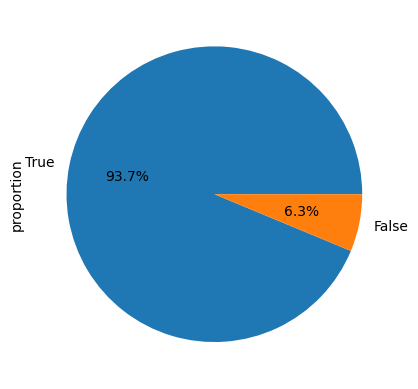

In [3]:
# How many occurrences of the interesting forms are actually in italy?
tokens["country_code"].eq("IT").value_counts(normalize=True).plot(
    kind="pie", autopct="%1.1f%%"
)

In [4]:
regions = gpd.read_file(
    filename=r"https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson"
)
regions.set_index("reg_istat_code", inplace=True)
regions.drop(columns=["reg_name", "reg_istat_code_num"], inplace=True)

In [5]:
choros = (
    tokens.groupby(["wf", "country_code", "reg_istat_code"], dropna=False)
    .size()
    .reset_index(name="count")
    .merge(pd.DataFrame(regions), on="reg_istat_code", how="left")
)

choros = gpd.GeoDataFrame(choros._to_pandas())

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Exception in thread Thread-62 (call_progress_bar):
Traceback (most recent call last):
  File "/opt/share/spack/spack-0.19.1/opt/spack/linux-ubuntu22.04-x86_64/gcc-12.1.0/python-3.10.8-qkx5vsyopsbqtvrf6y2bf7aviocikm4m/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/share/spack/spack-0.19.1/opt/spack/linux-ubuntu22.04-x86_64/gcc-12.1.0/python-3.10.8-qkx5vsyopsbqtvrf6y2bf7aviocikm4m/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/clusterusers/pbrasolin_eurac/jupyter/lib/python3.10/site-packages/modin/core/execution/modin_aqp.py", line 61, in call_progress_bar
    futures = [
  File "/home/clusterusers/pbrasolin_eurac/jupyter/lib/python3.10/site-packages/modin/core/execution/modin_aqp.py", line 61, in <listcomp>
    futures = [
TypeError: 'PandasOnRayDataframePartition' object is not iterable


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [6]:
sums = choros.groupby("wf")["count"].sum().to_dict()

sorted_wf = choros.groupby("wf").sum("count")["count"].sort_values(ascending=False)
sorted_choros = choros.set_index("wf").loc[sorted_wf.index].reset_index()

def annotate(data, pbar=None, **kws):
    if pbar:
        pbar.update(1)
    wf = data["wf"].iloc[0]
    ax = plt.gca()

    if data["reg_istat_code"].any():
        data.plot(
            column="count",
            ax=ax,
            legend=True,
            cmap="viridis",
            vmin=0,
            aspect=1/np.cos((36.688444+47.083333)/2 * np.pi/180), # it's 'auto' from geopandas, but we set it
        )
    
    ax.set_title("{} ({})".format(wf, sums[wf]))
    foreign = data[data["reg_istat_code"].isna() & ~data["country_code"].eq("IT")][
        "count"
    ].sum()
    generic = data[data["reg_istat_code"].isna() & data["country_code"].eq("IT")][
        "count"
    ].sum()
    warning = ["Not shown:"]
    if generic:
        warning.append("{} generic".format(generic))
    if foreign:
        warning.append("{} foreign".format(foreign))

    if generic or foreign:
        ax.text(
            0,
            0,
            "\n".join(warning),
            transform=ax.transAxes,
            fontsize="small",
        )


  0%|          | 0/388 [00:00<?, ?it/s]

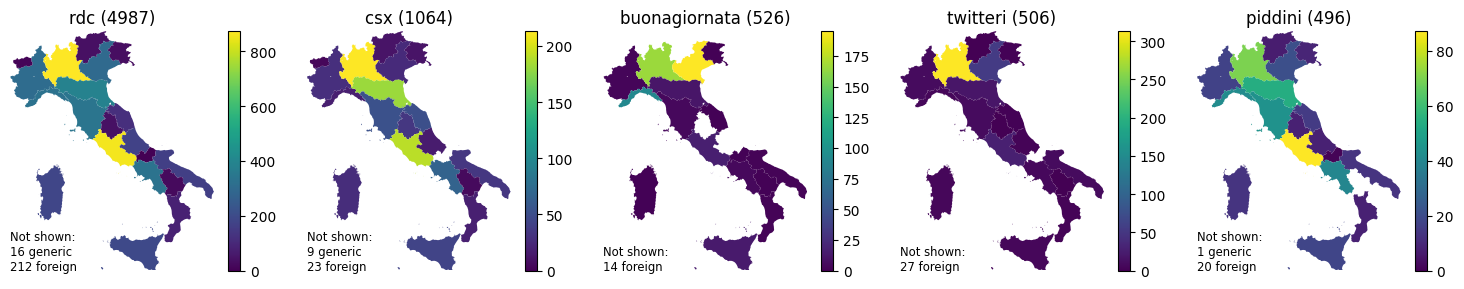

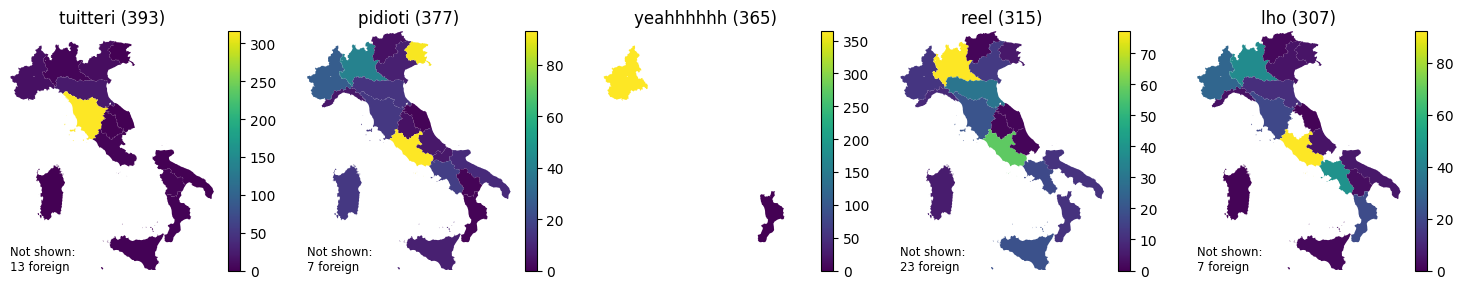

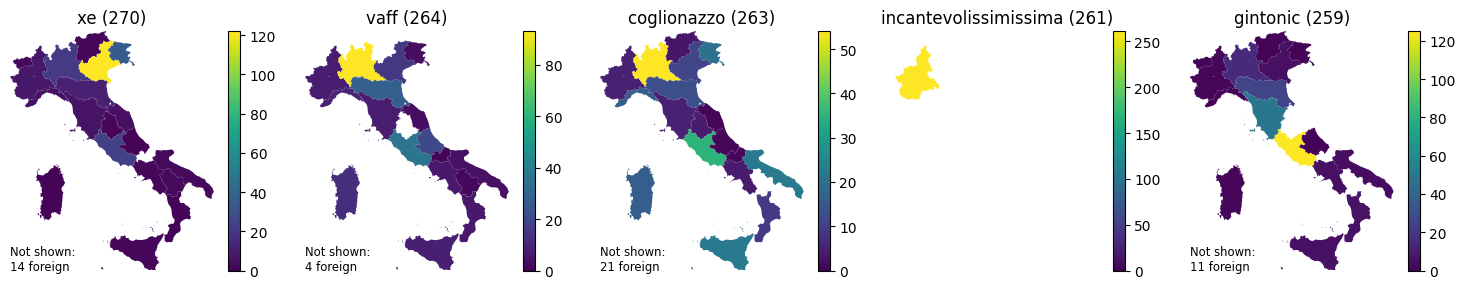

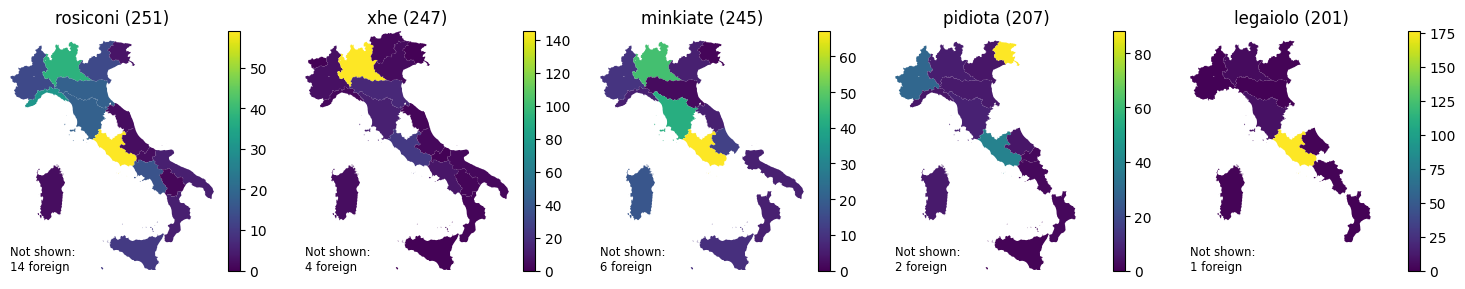

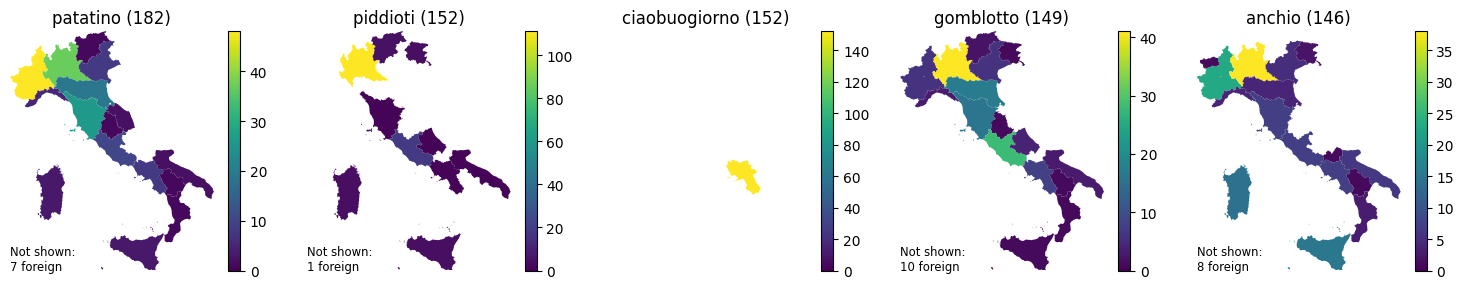

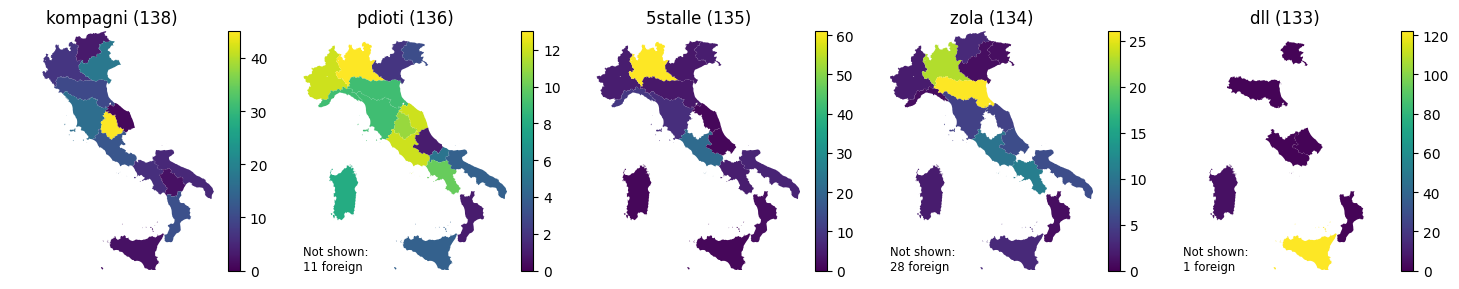

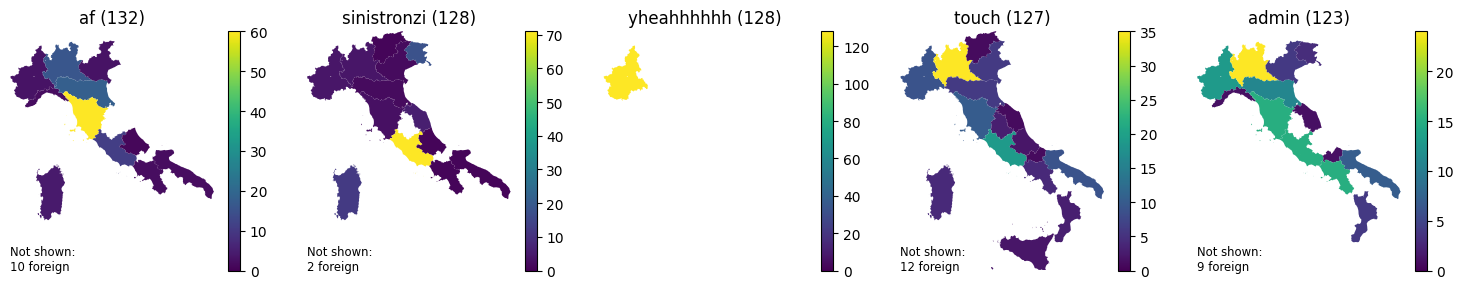

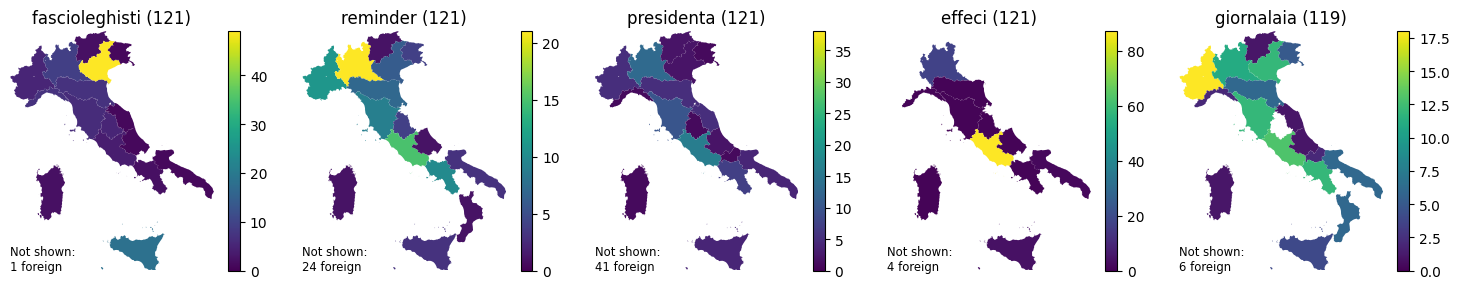

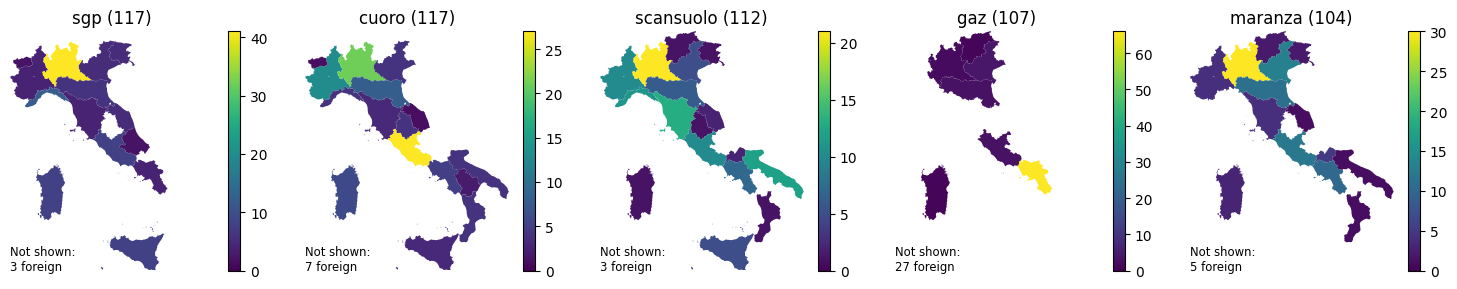

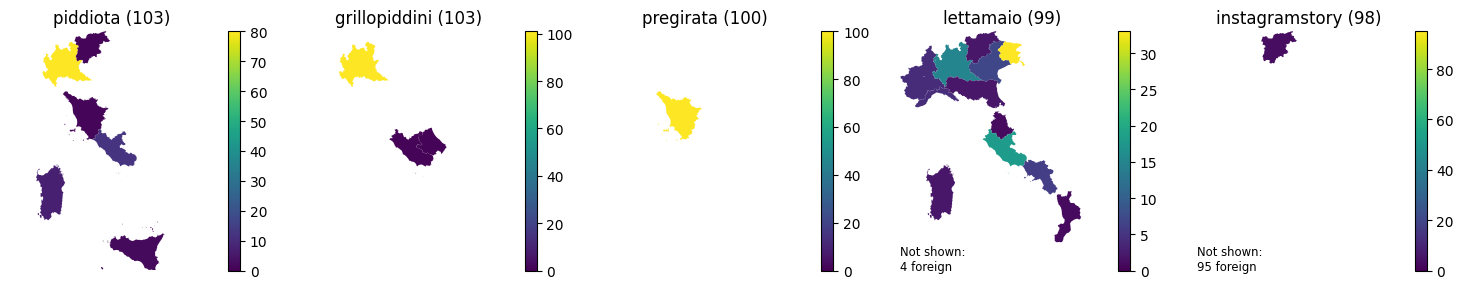

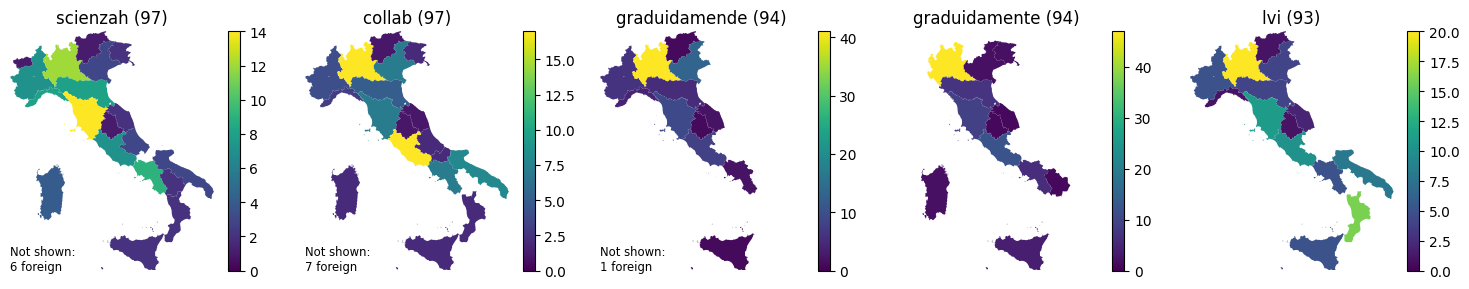

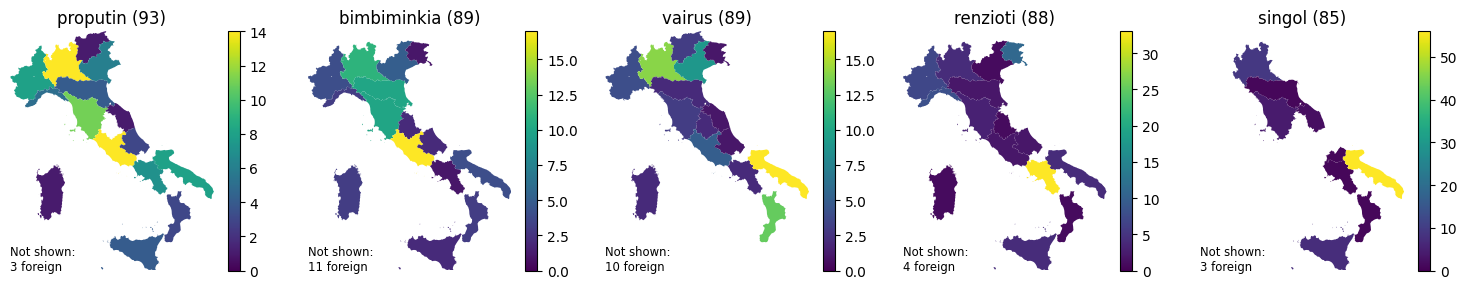

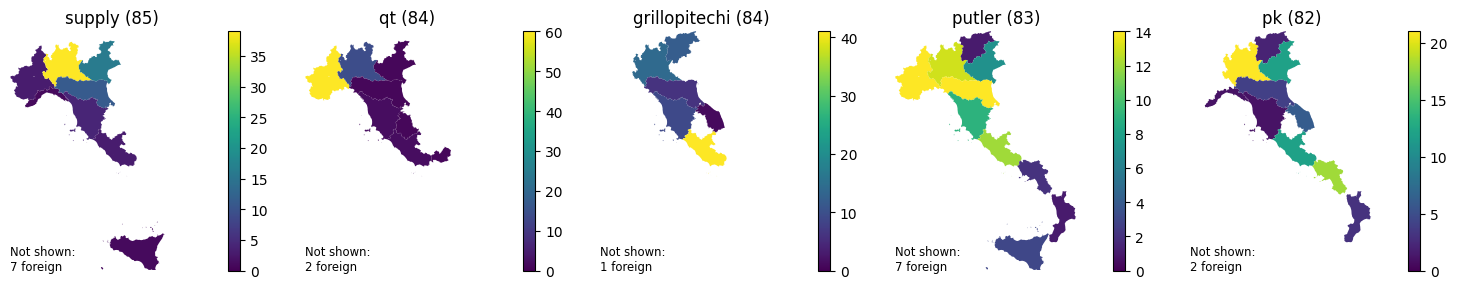

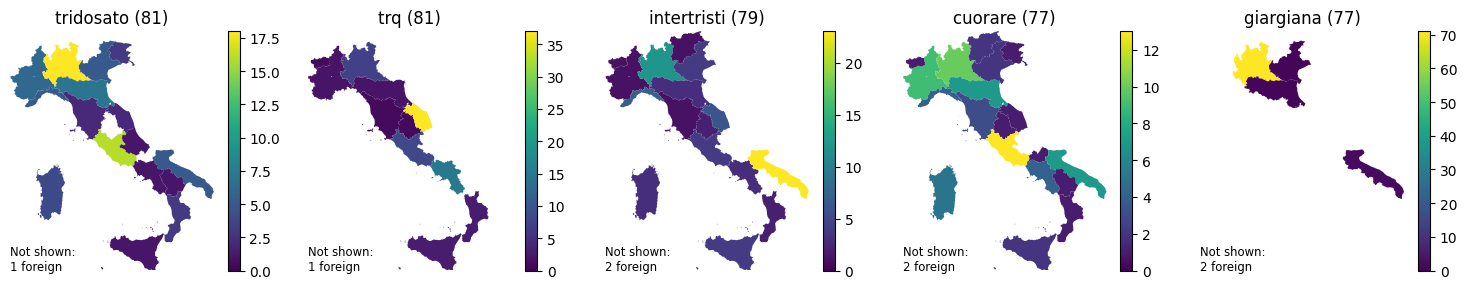

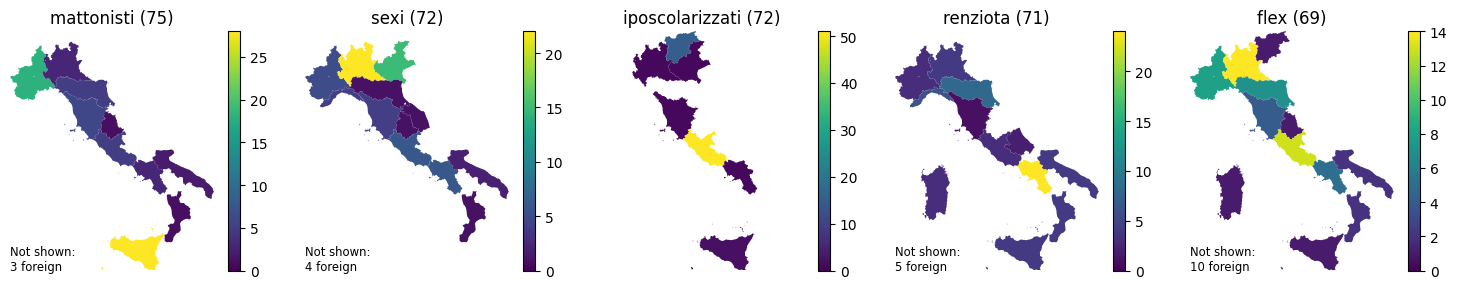

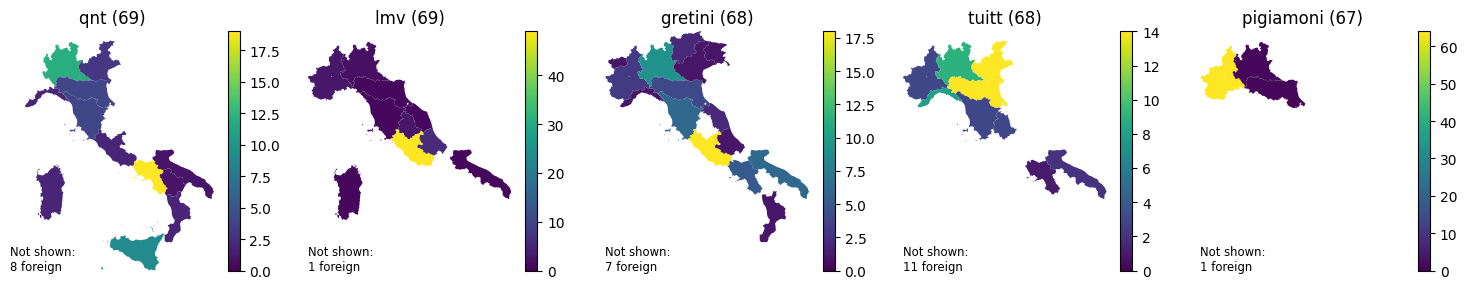

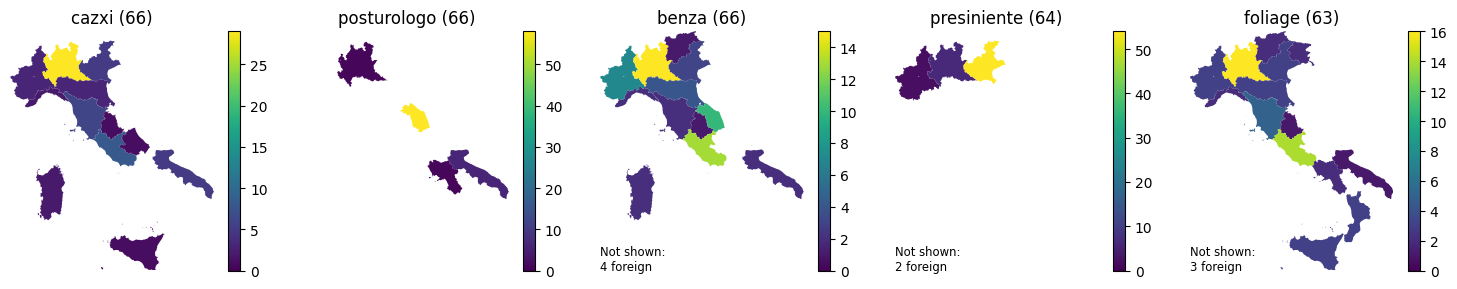

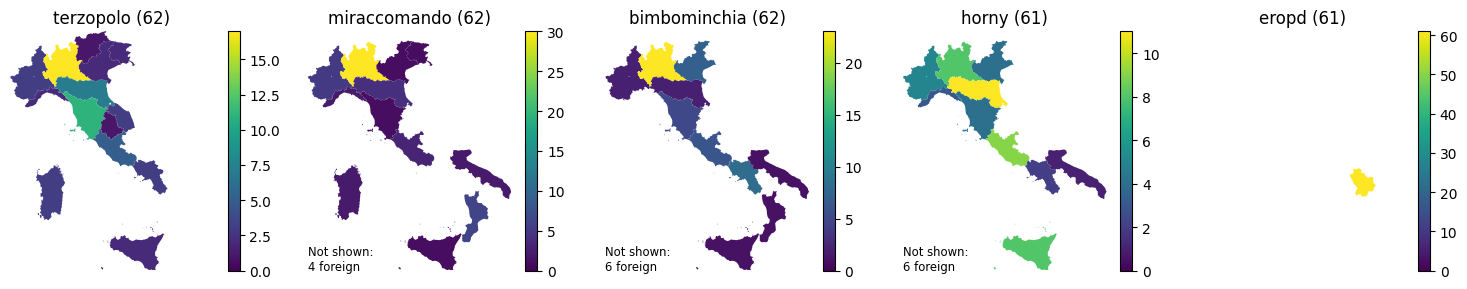

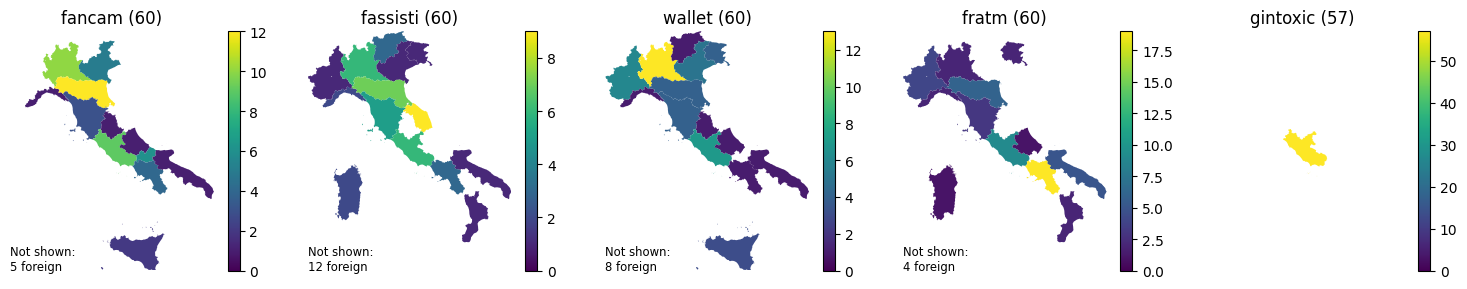

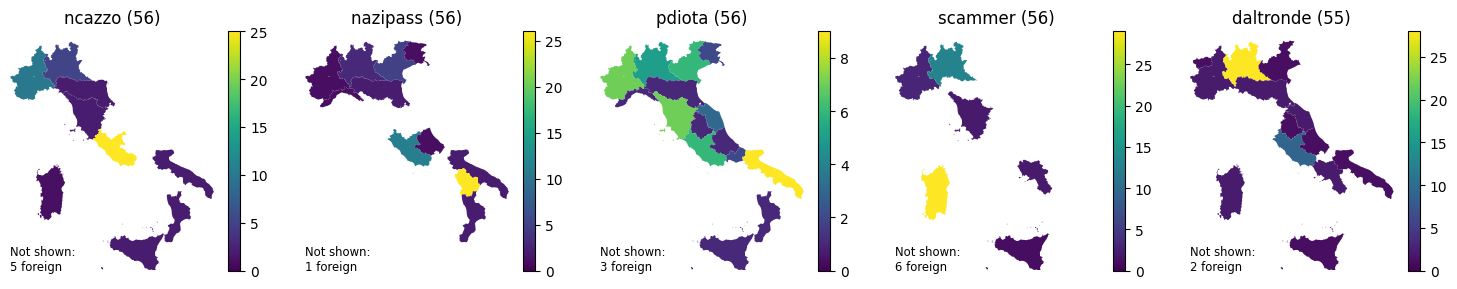

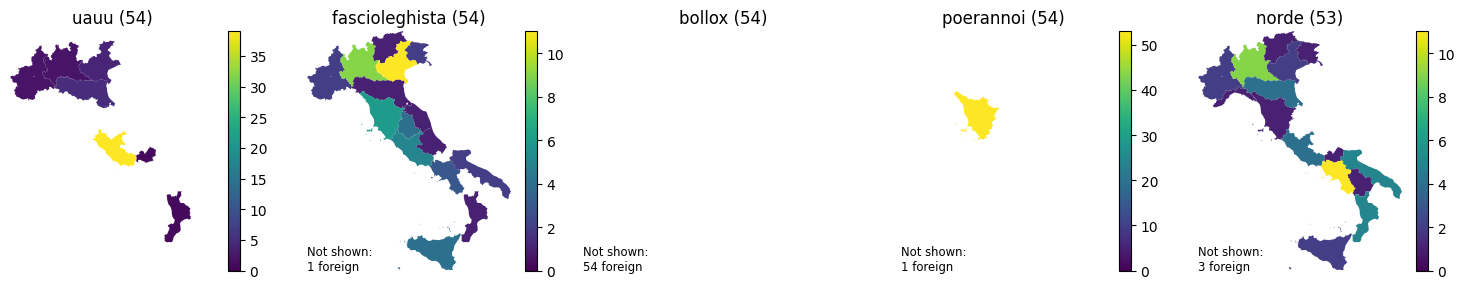

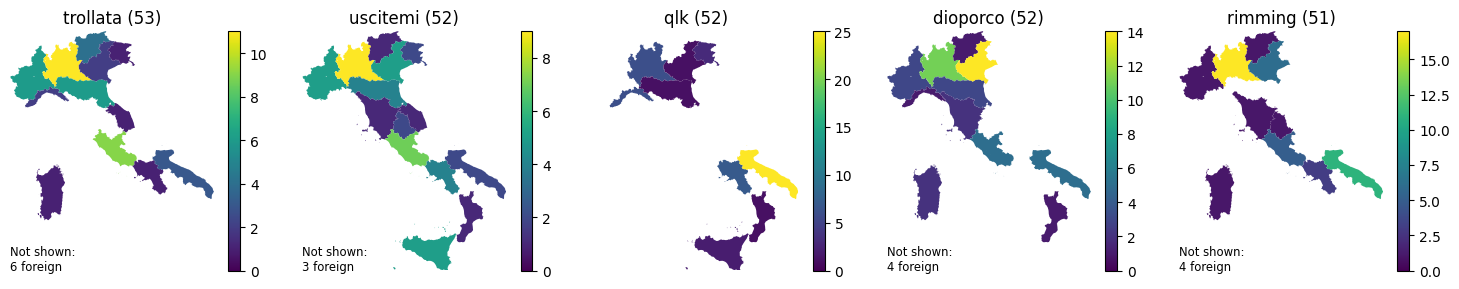

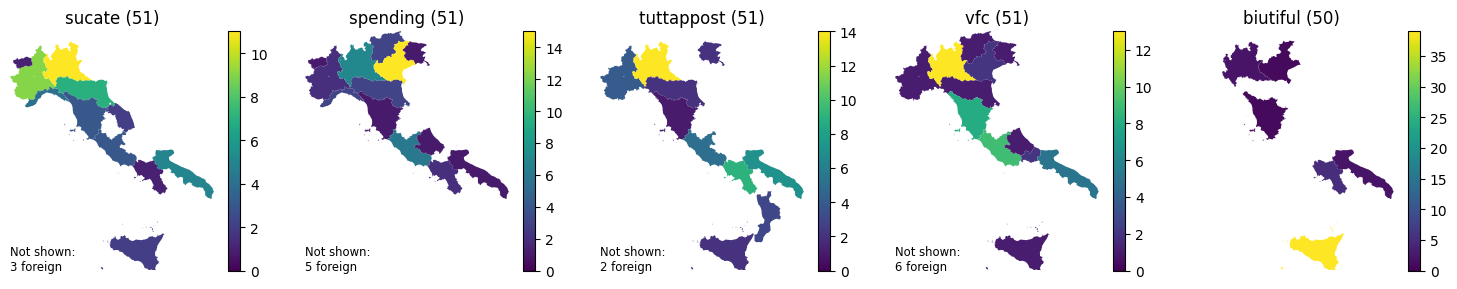

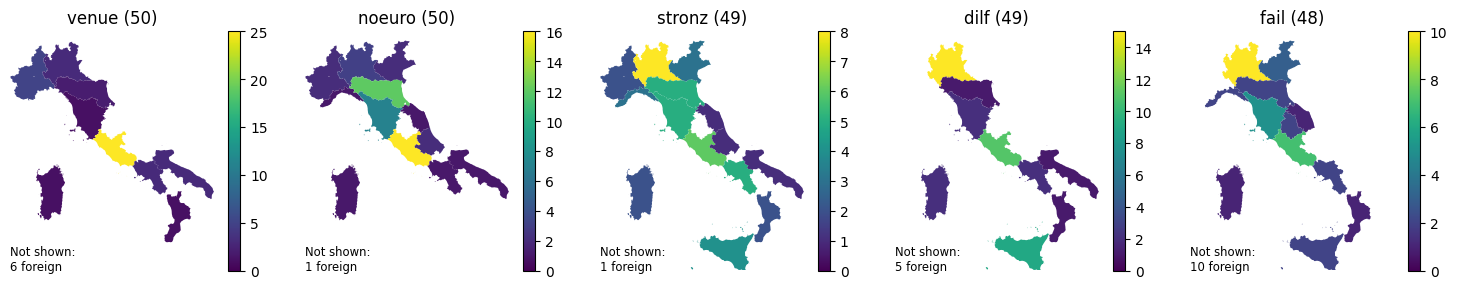

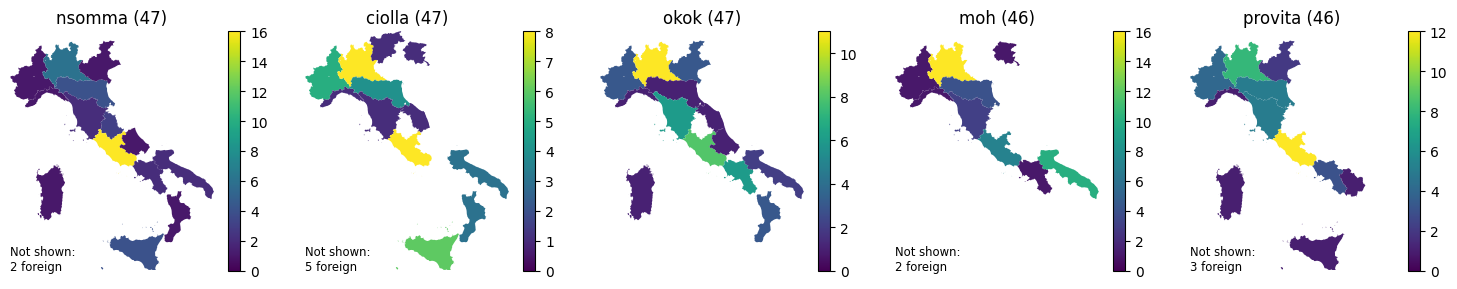

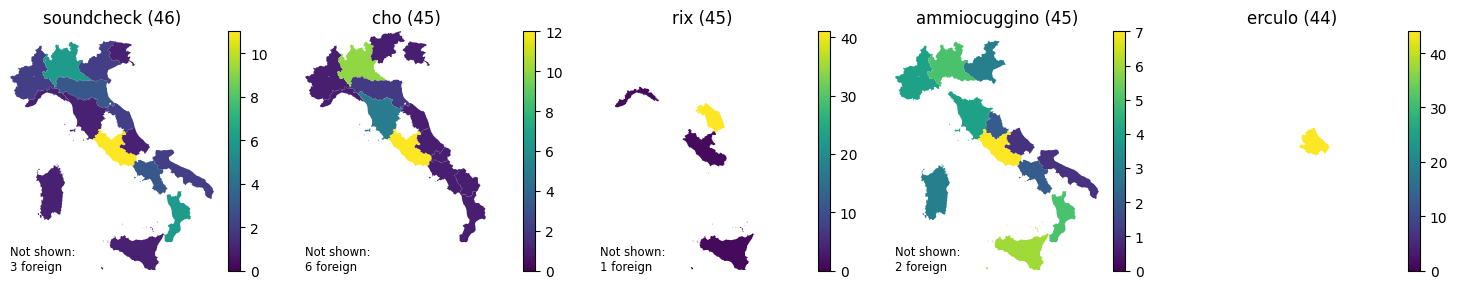

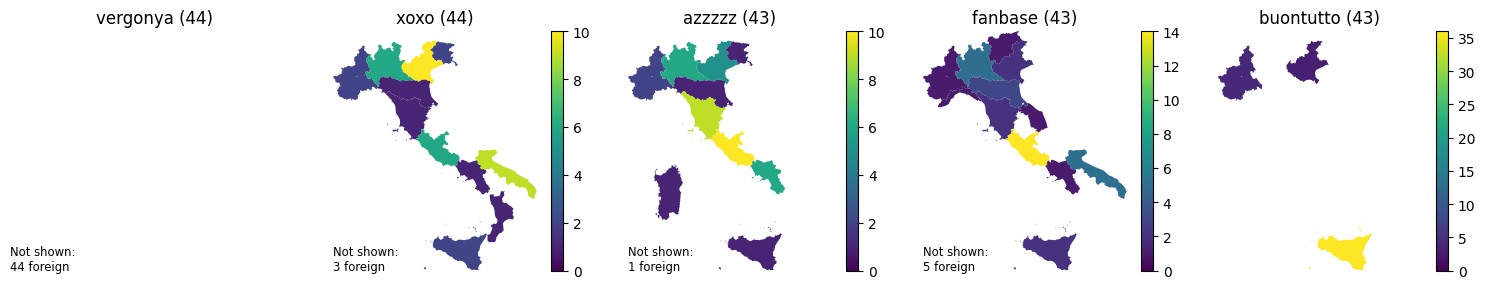

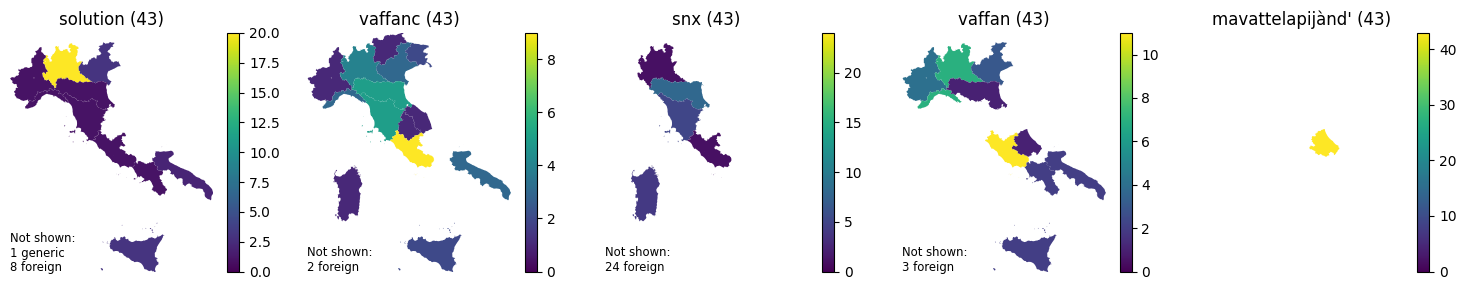

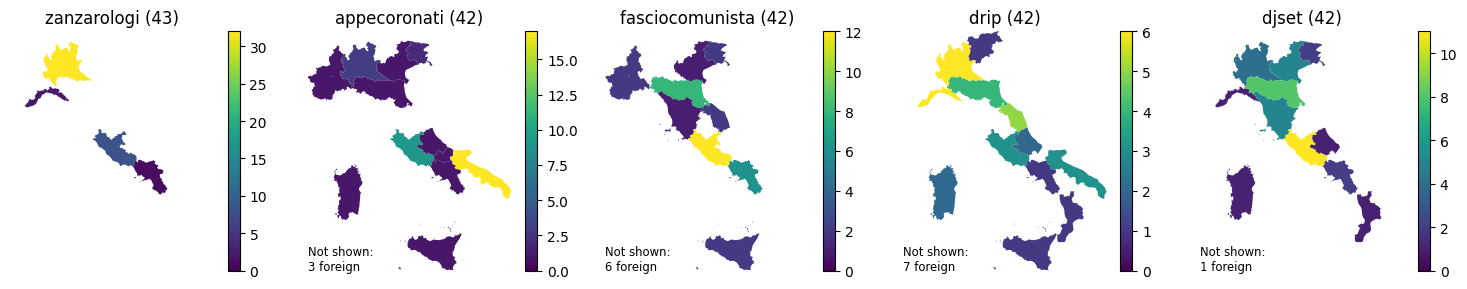

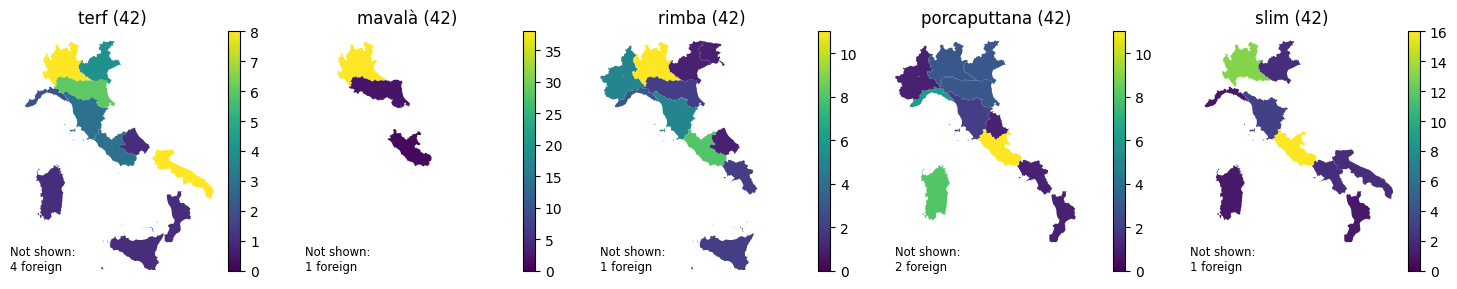

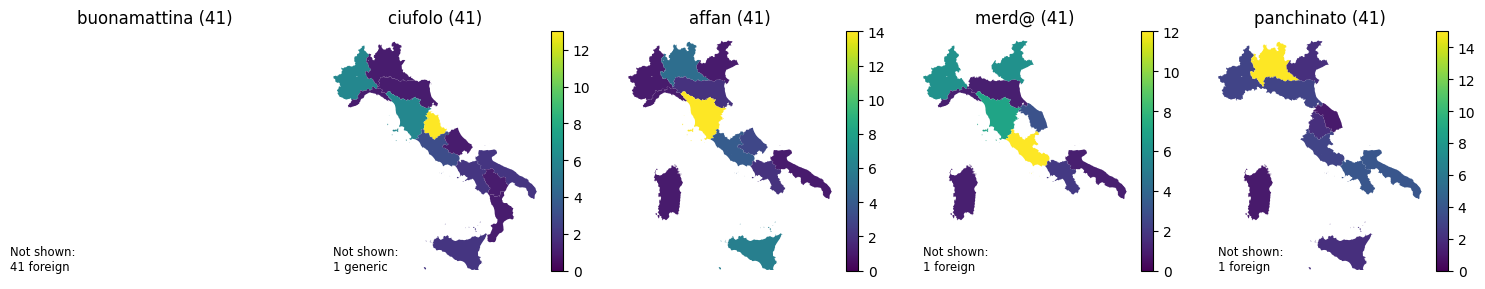

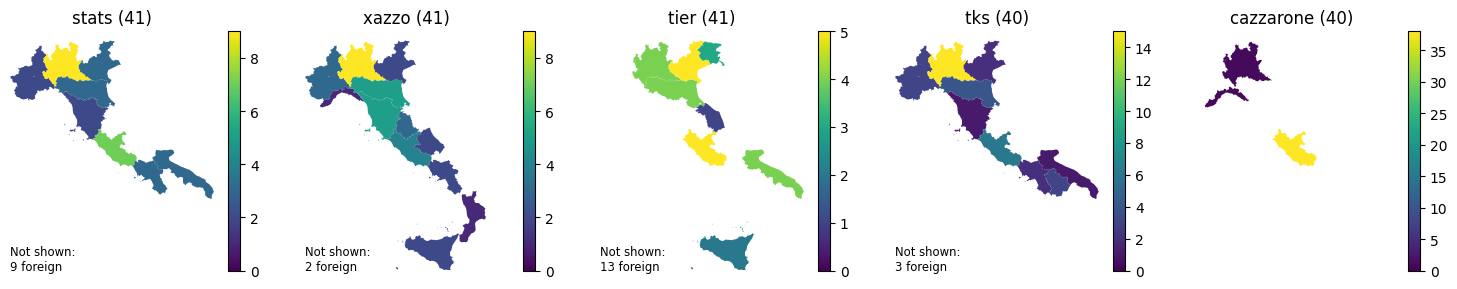

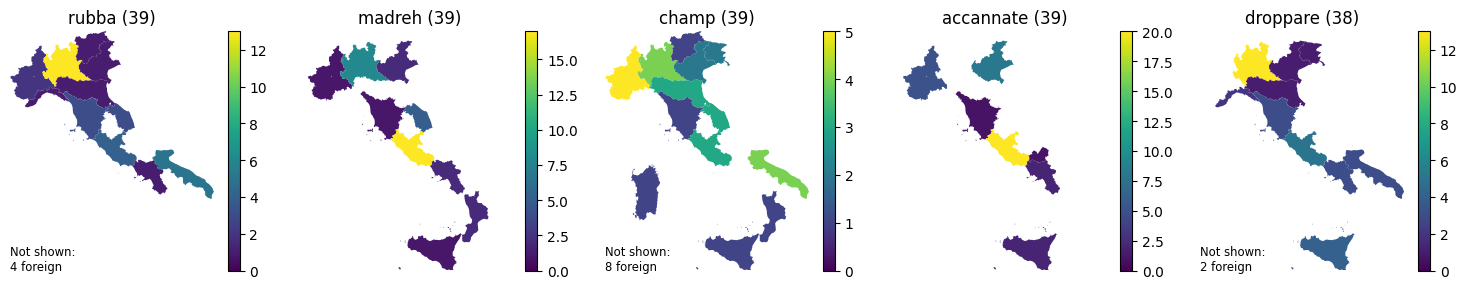

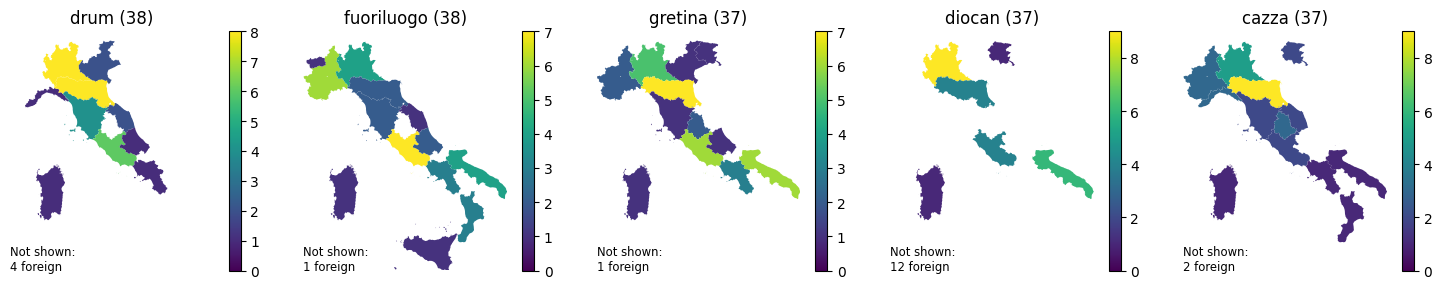

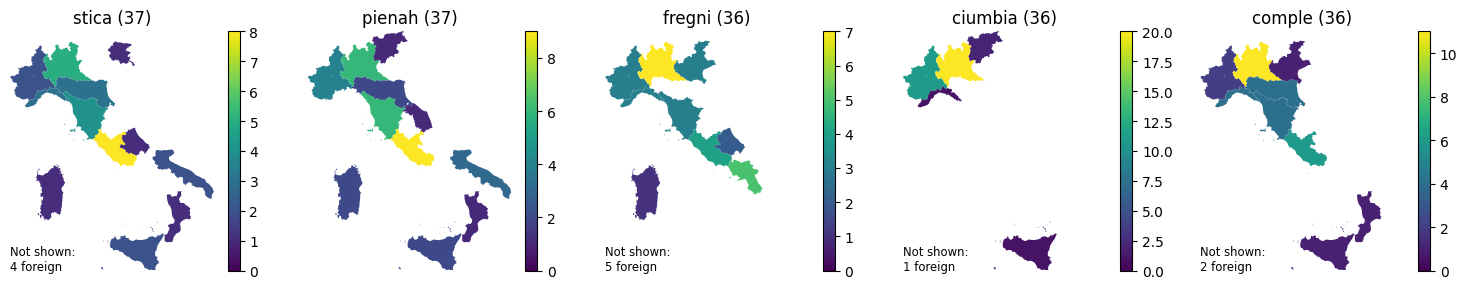

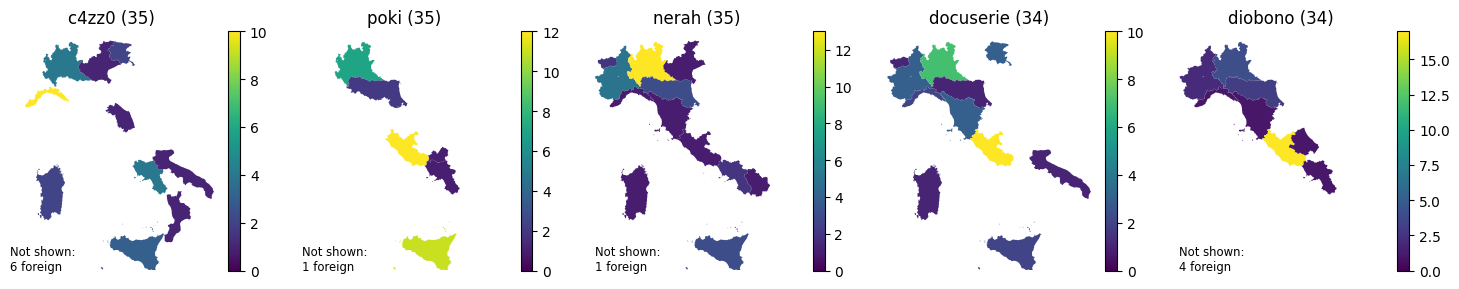

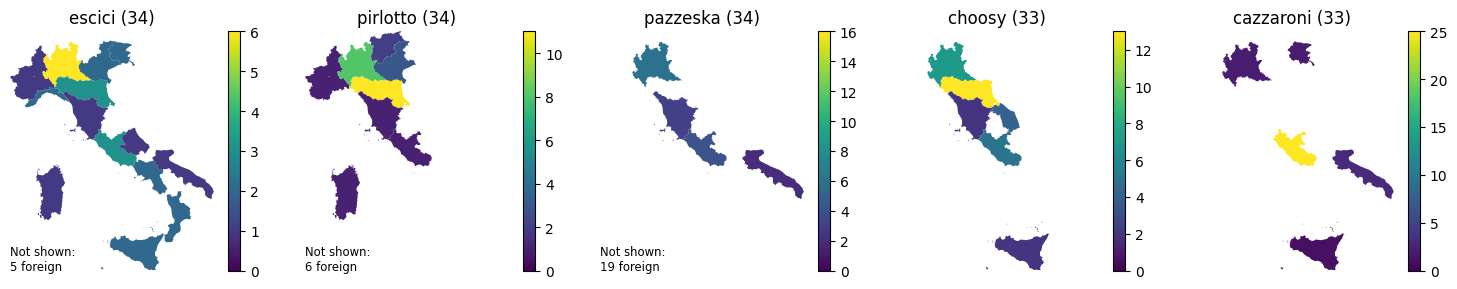

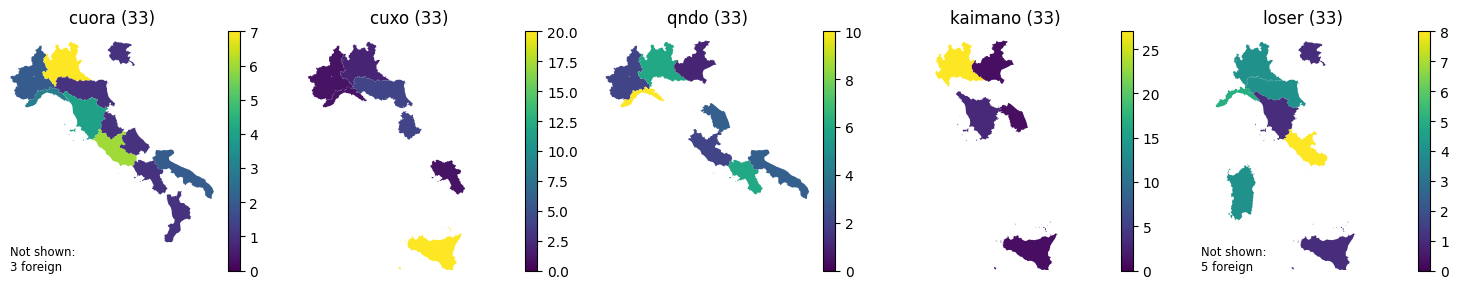

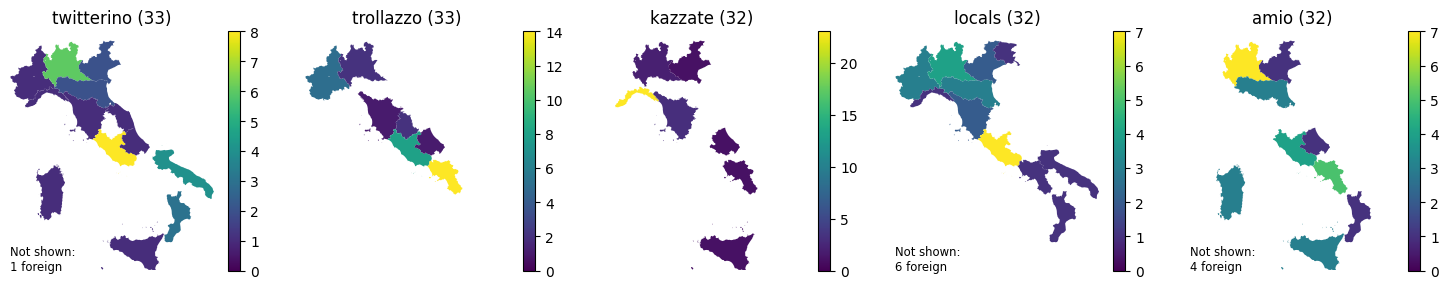

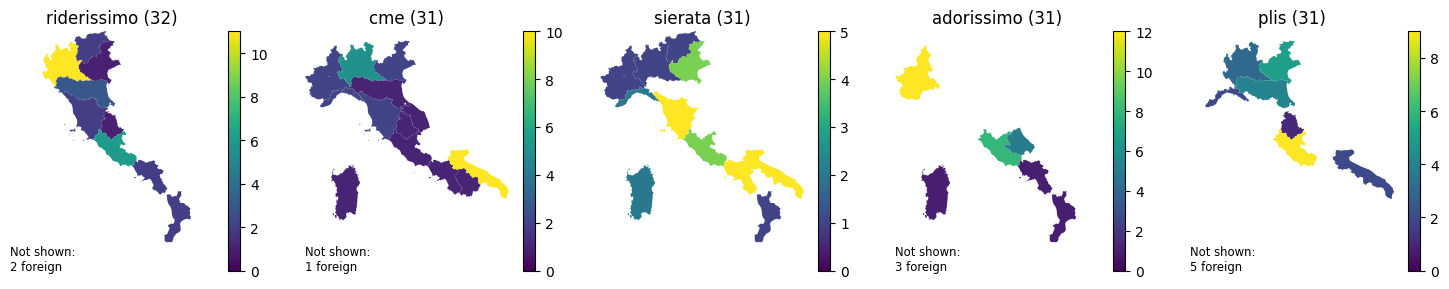

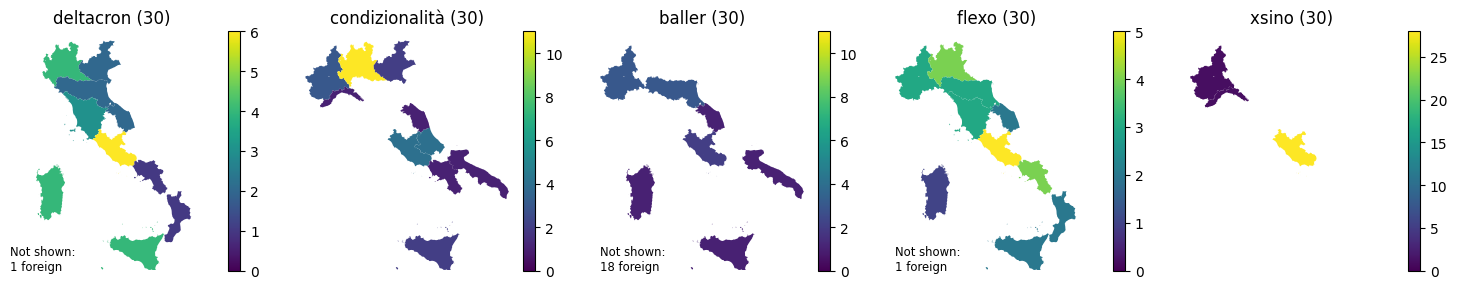

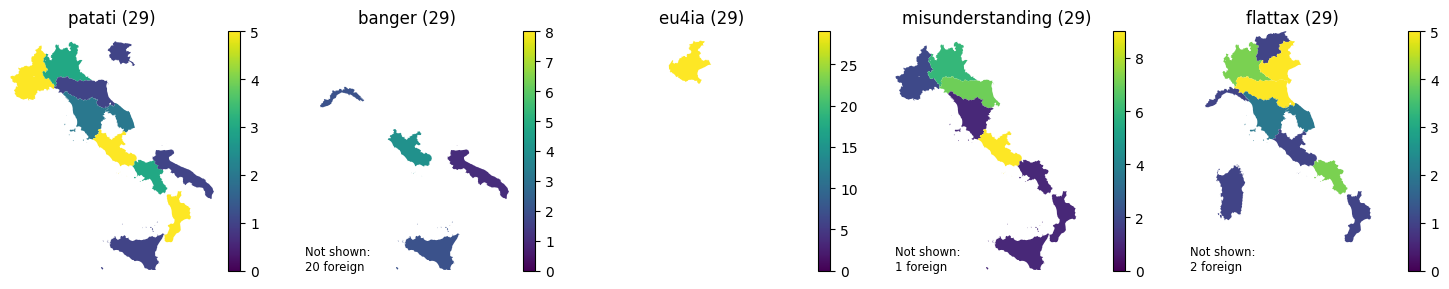

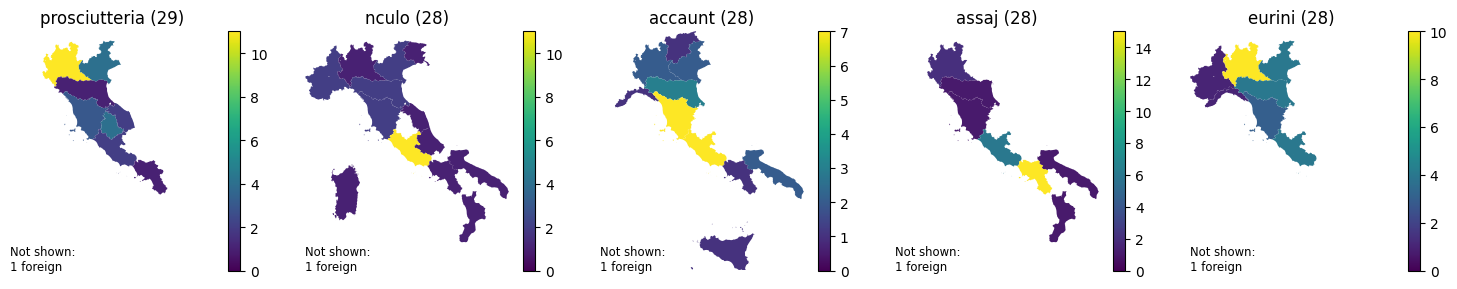

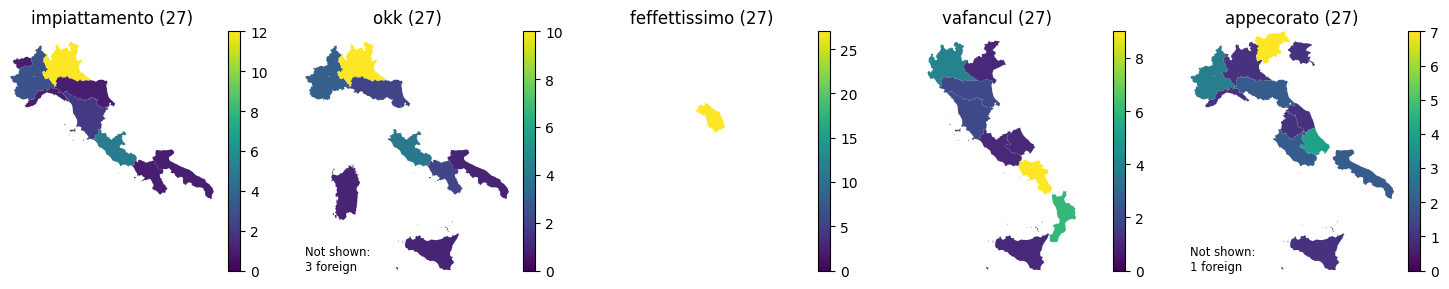

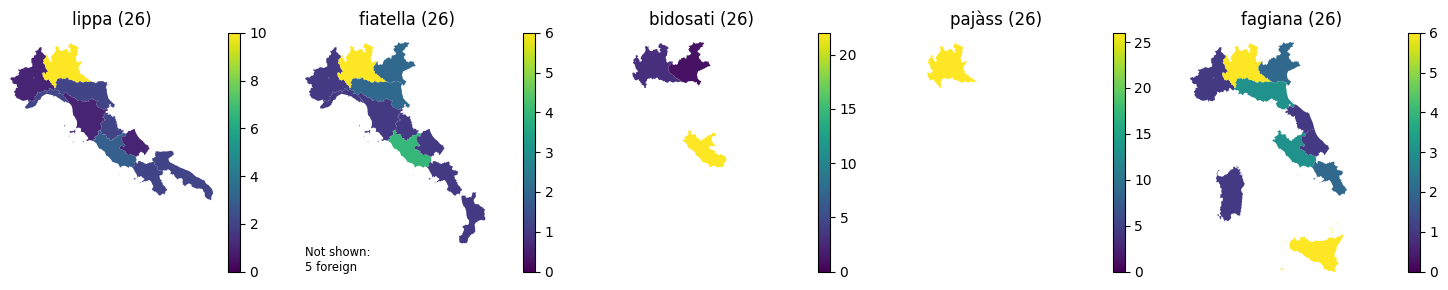

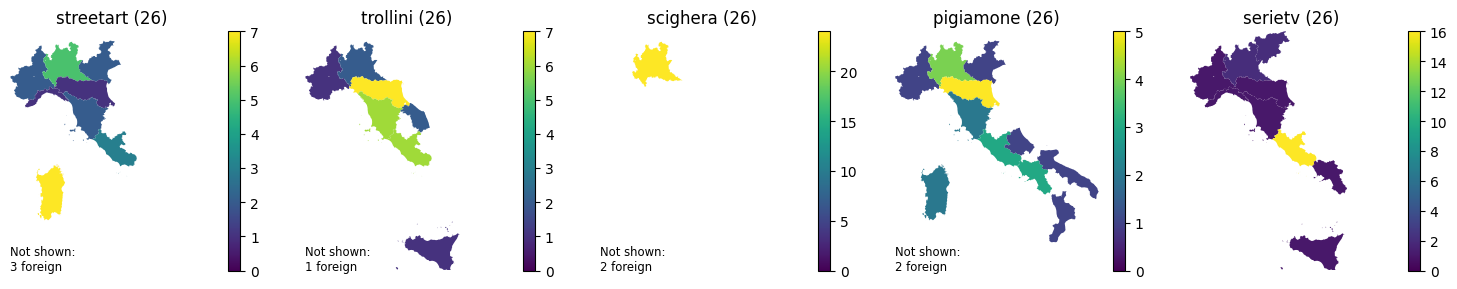

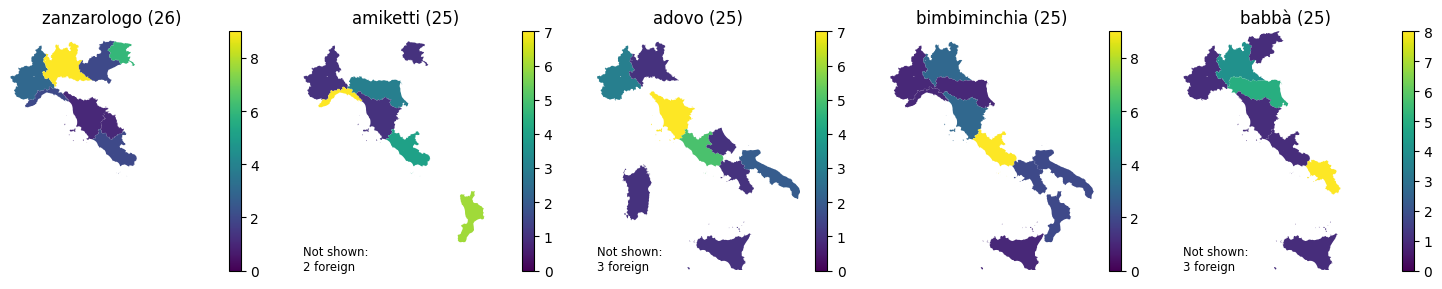

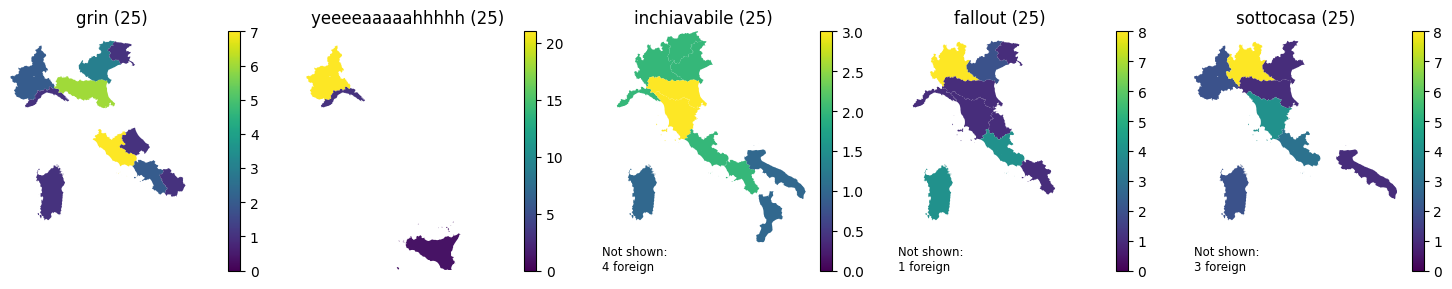

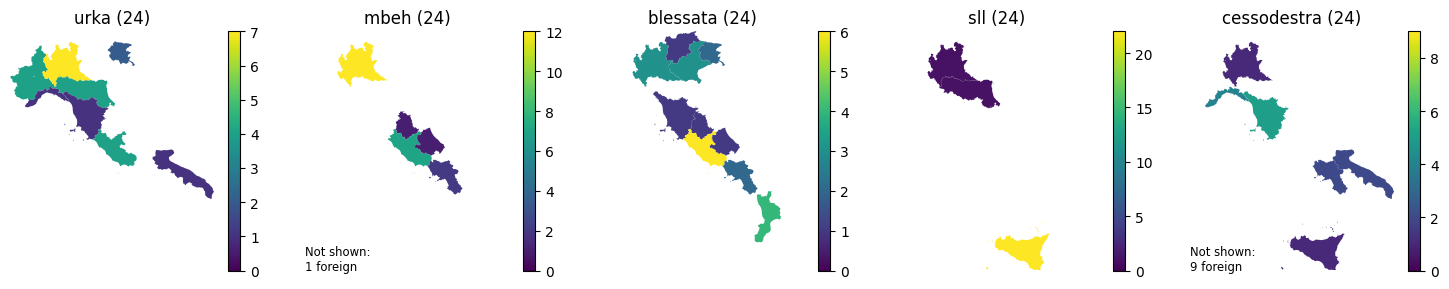

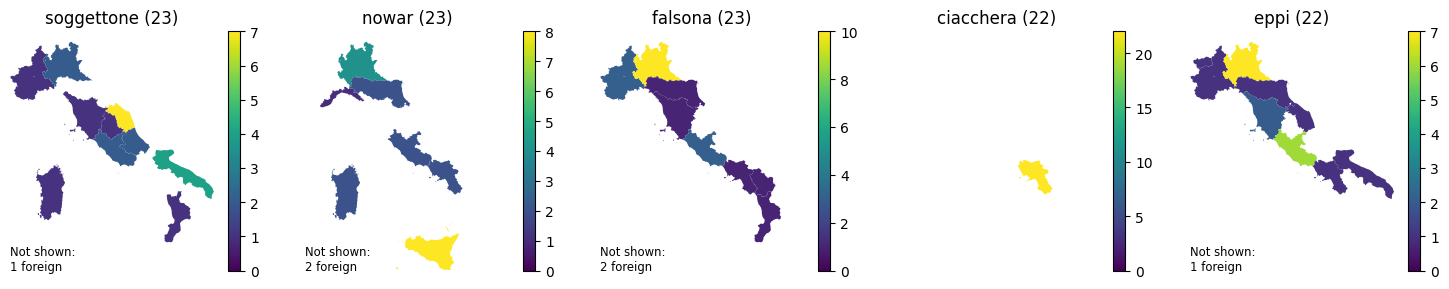

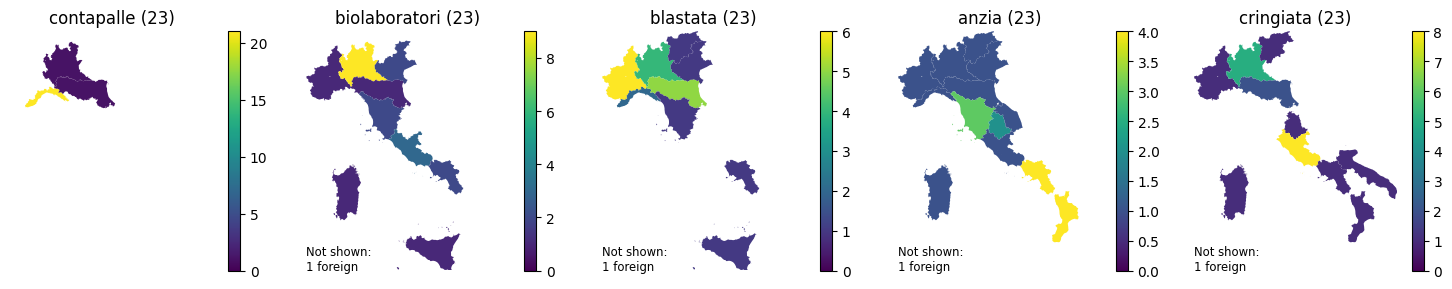

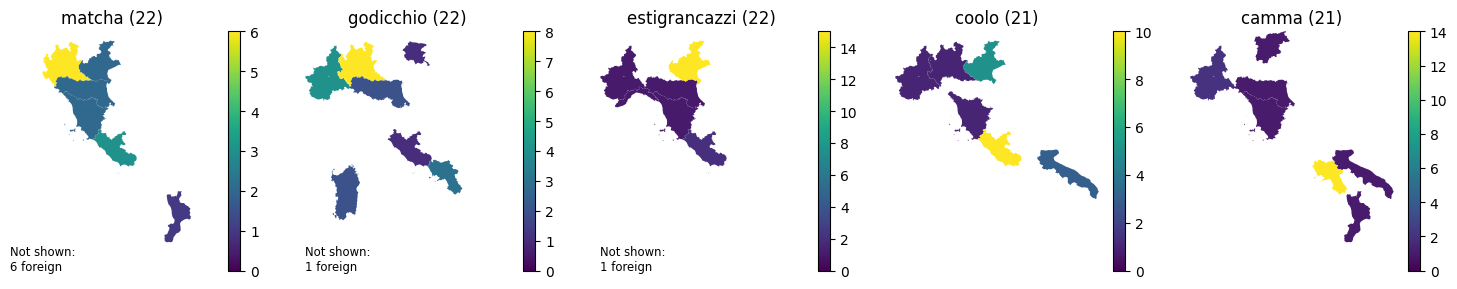

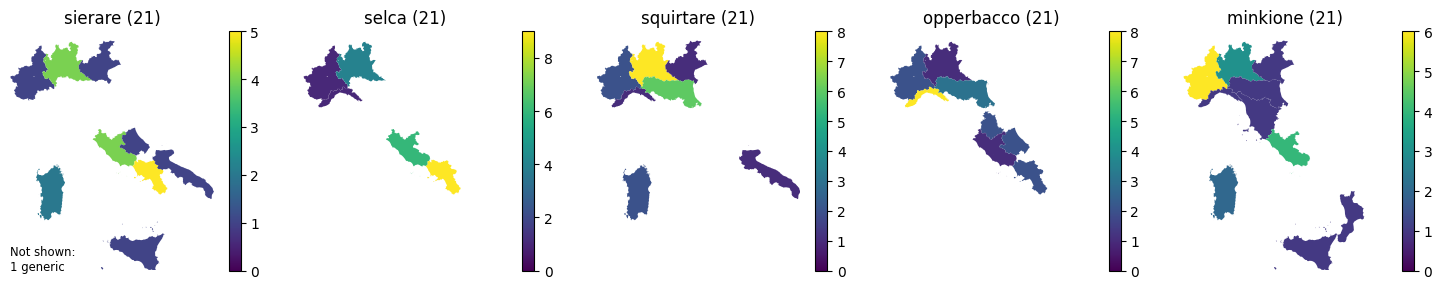

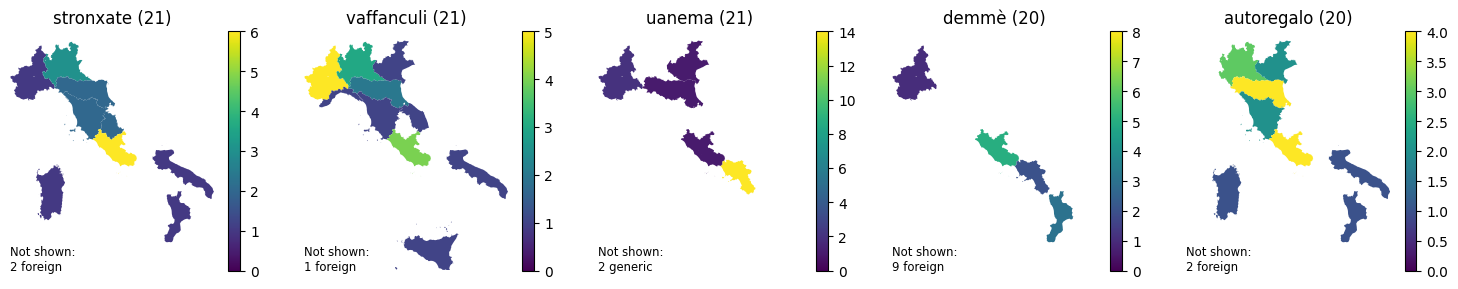

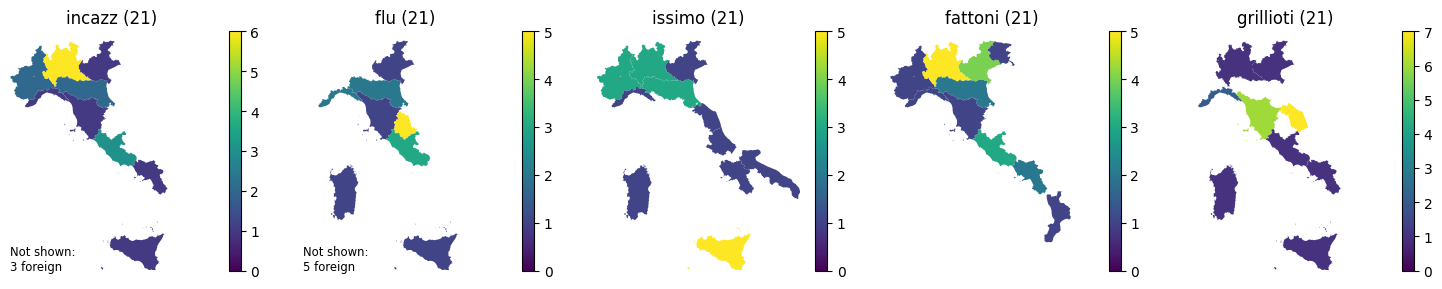

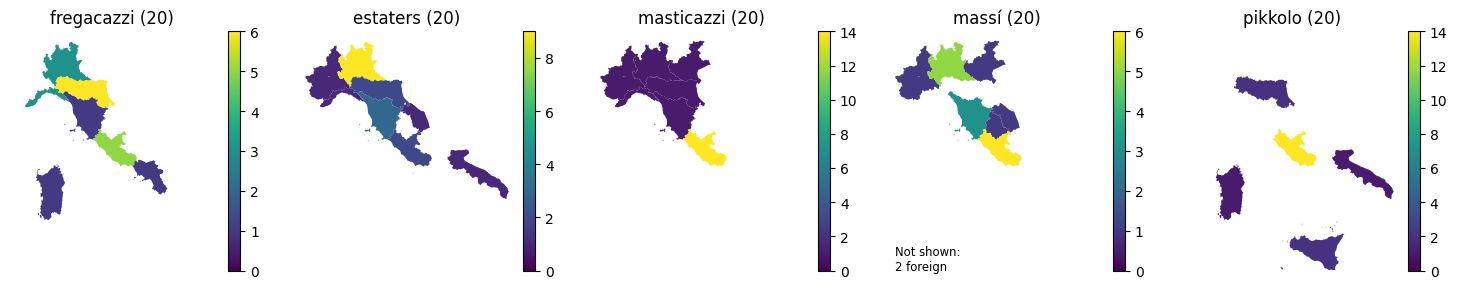

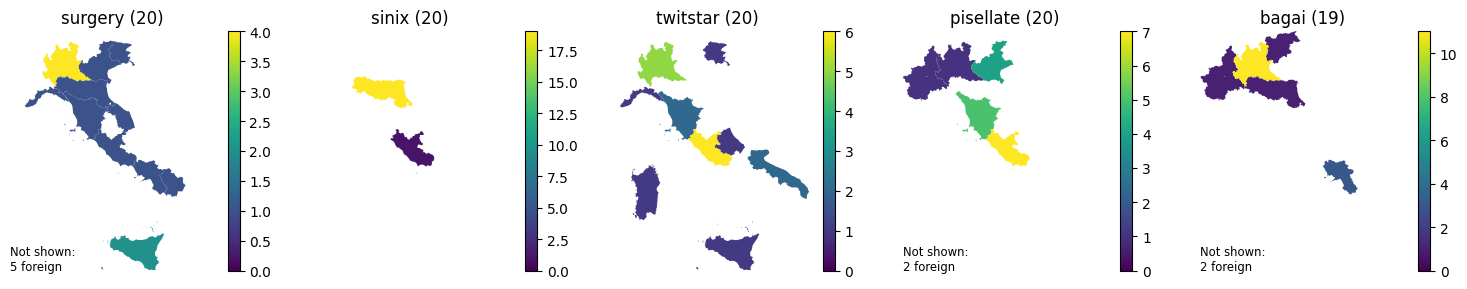

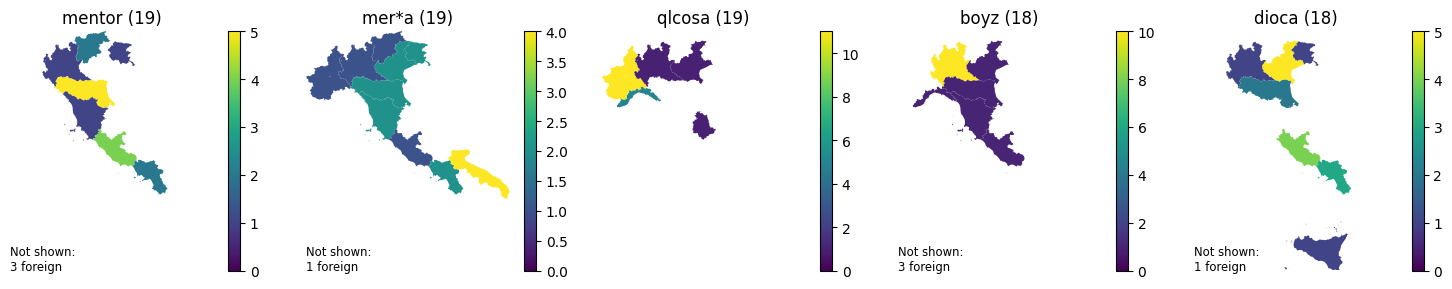

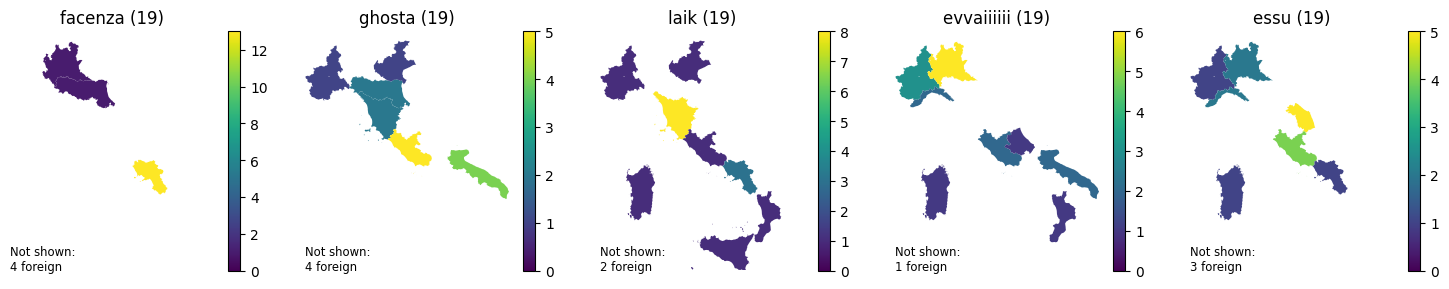

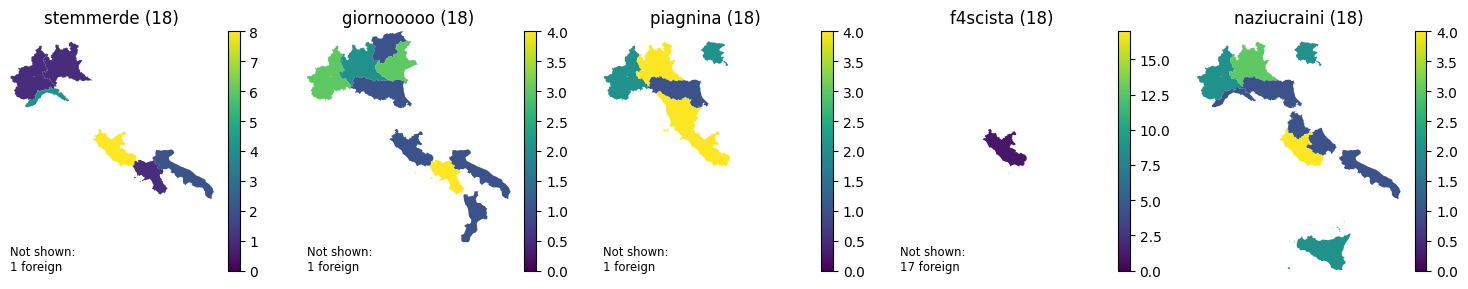

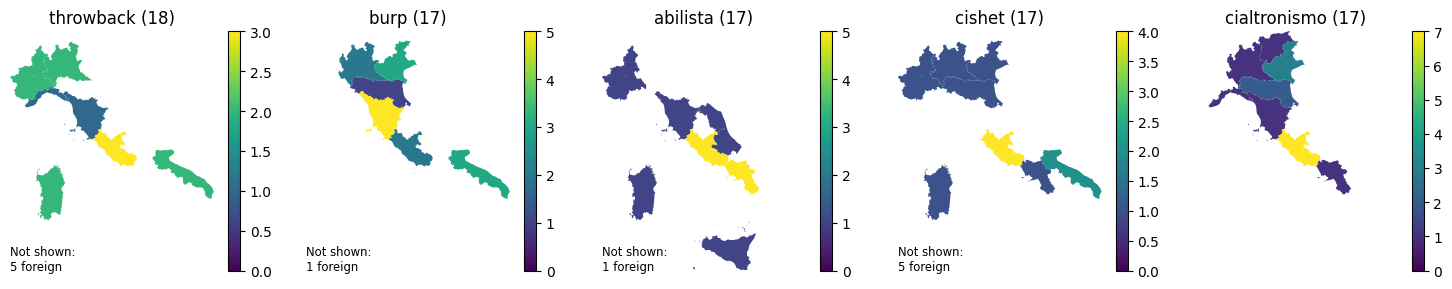

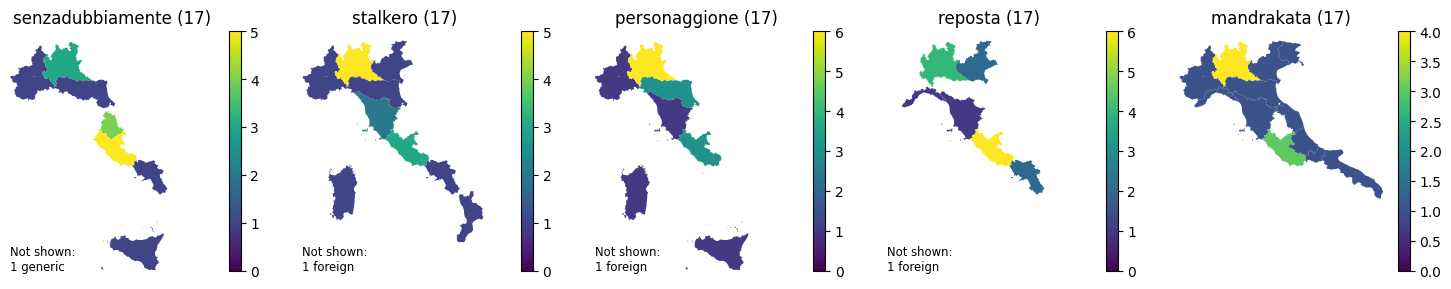

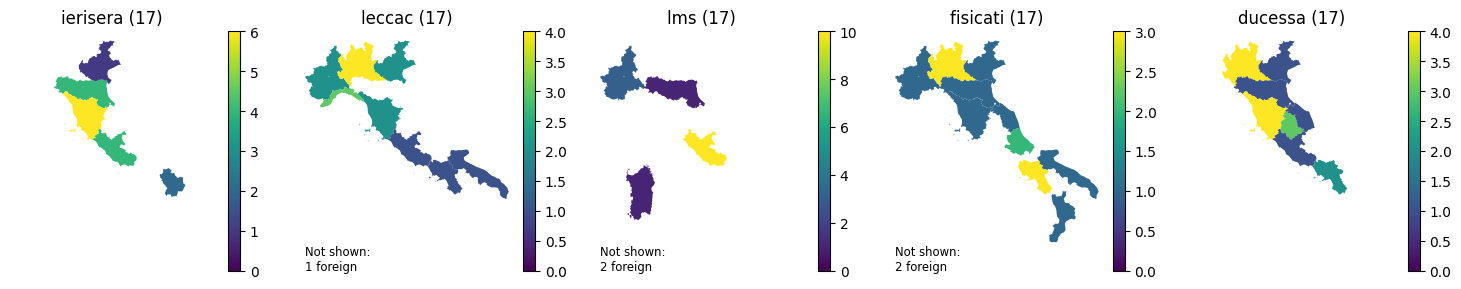

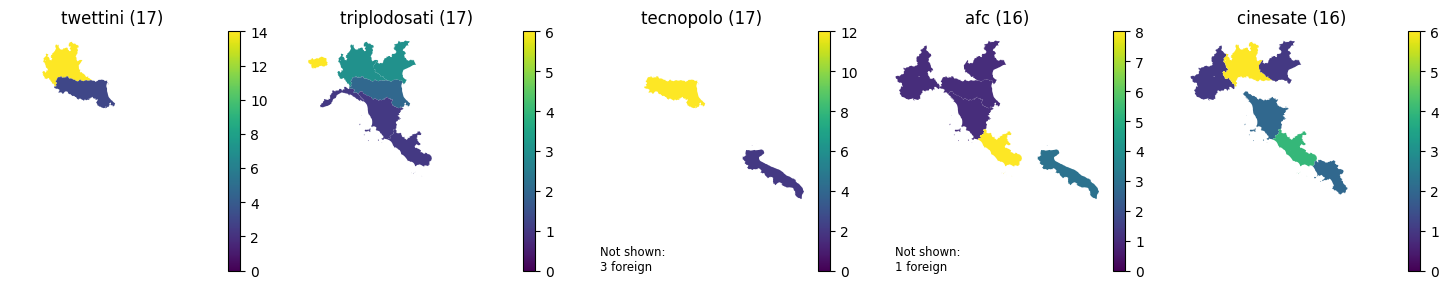

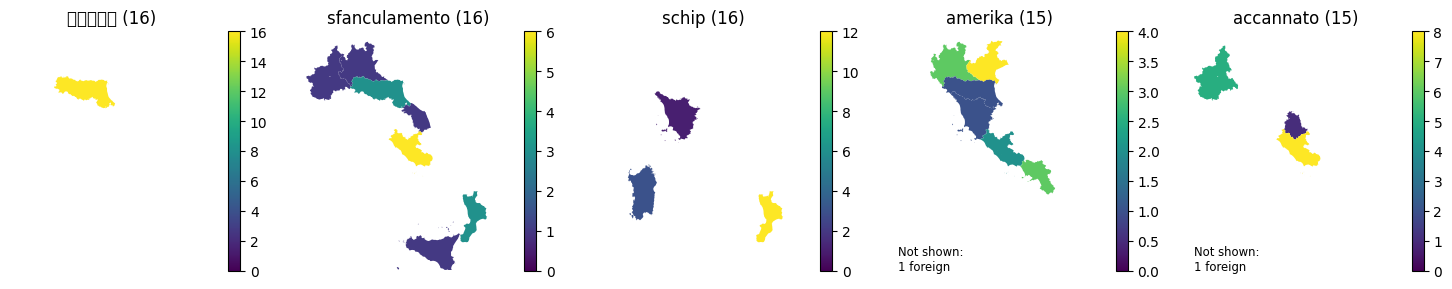

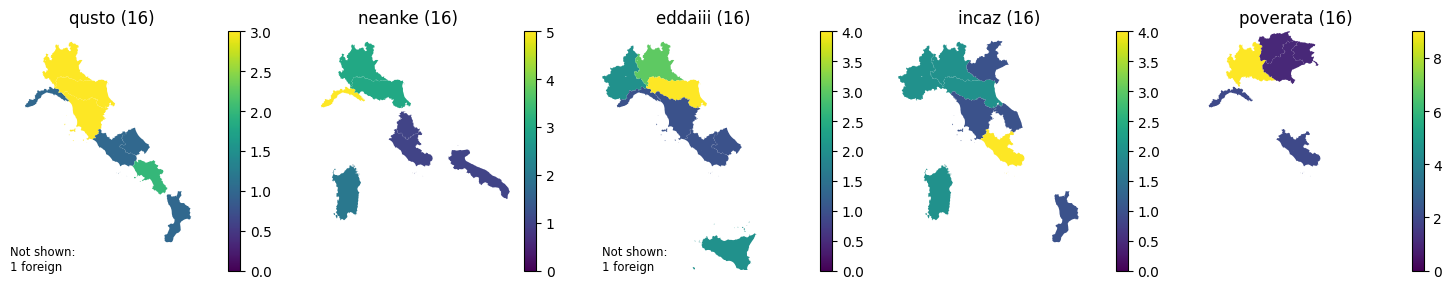

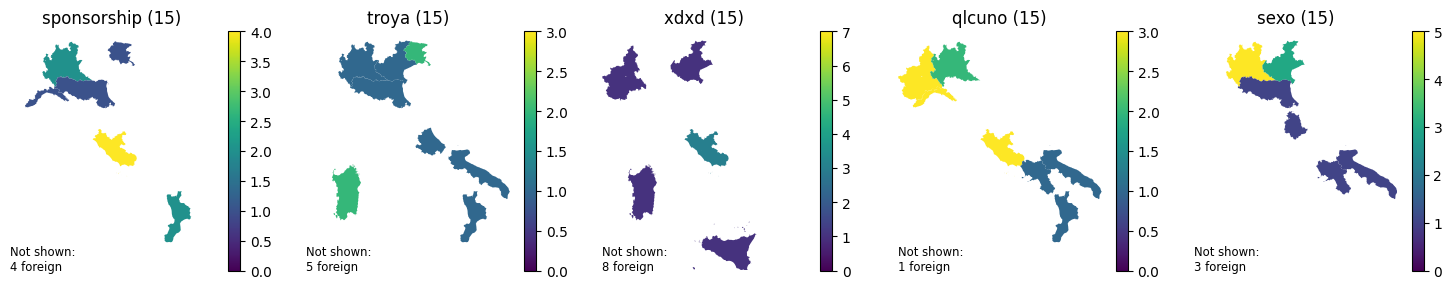

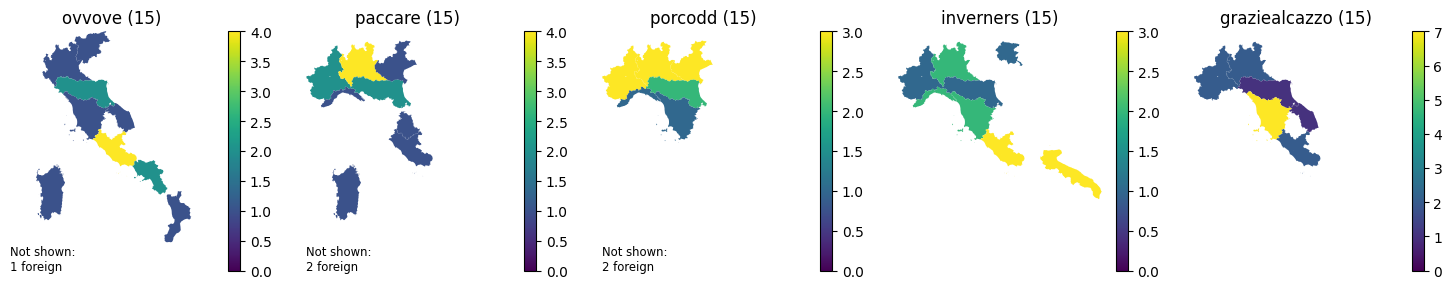

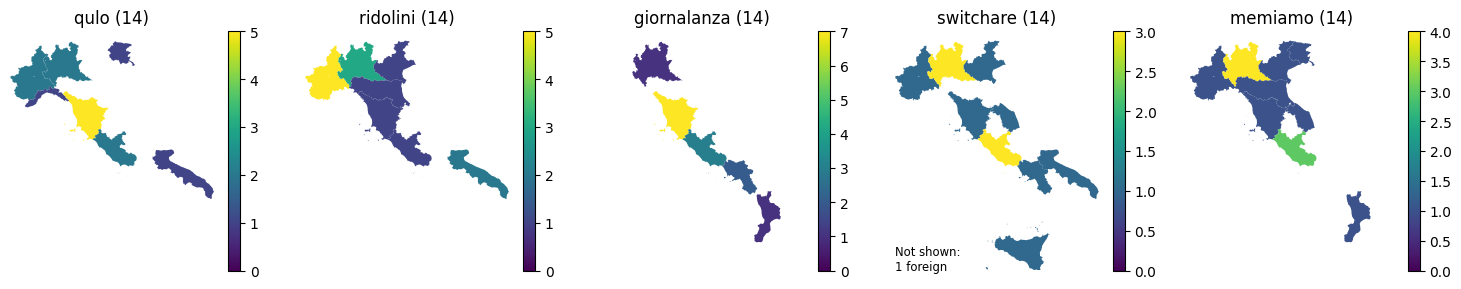

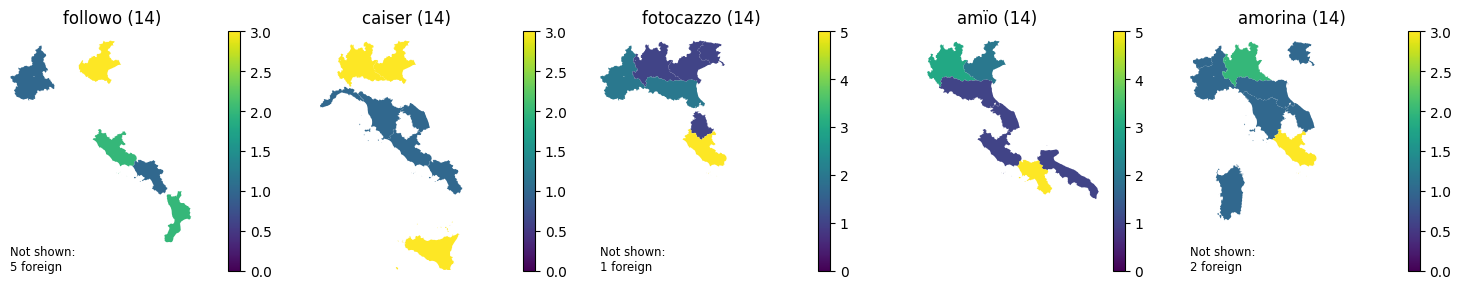

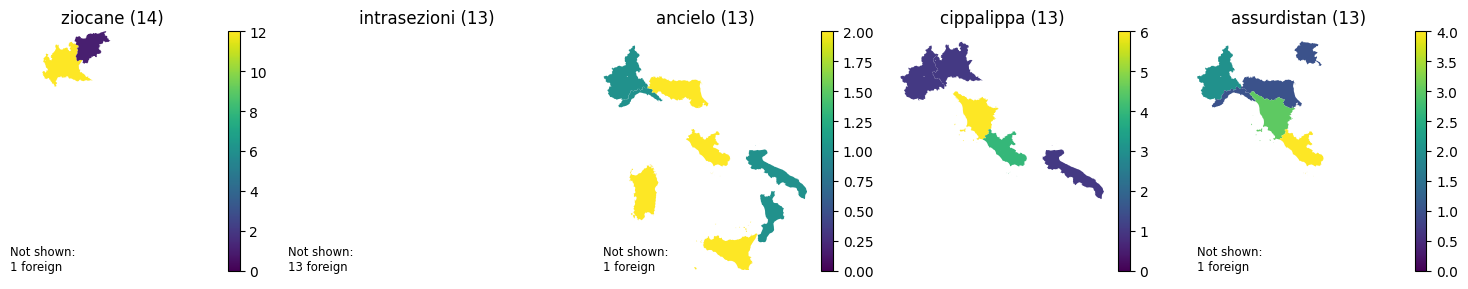

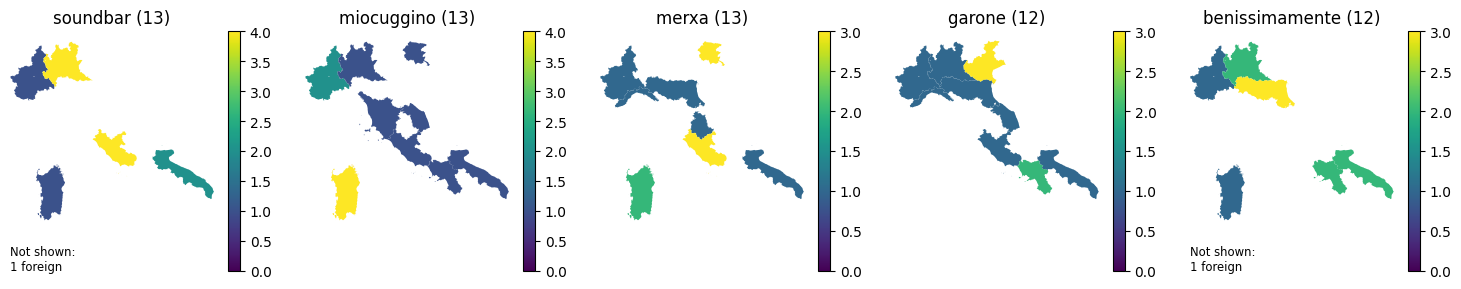

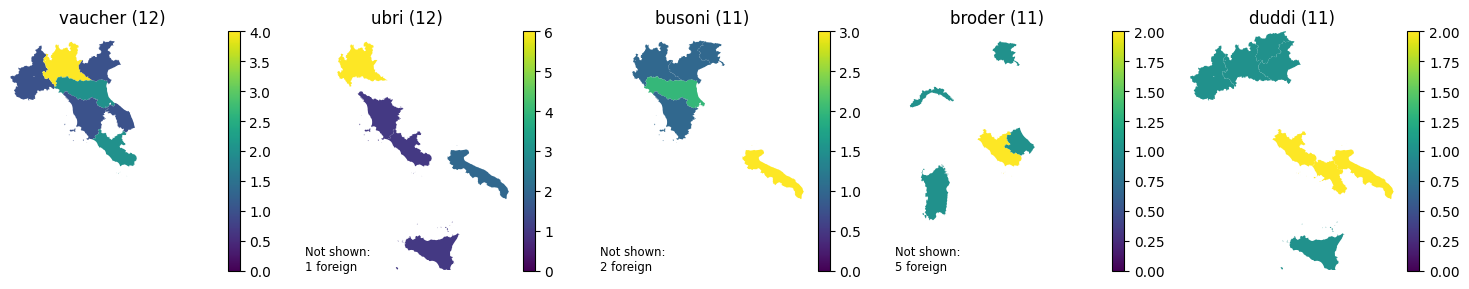

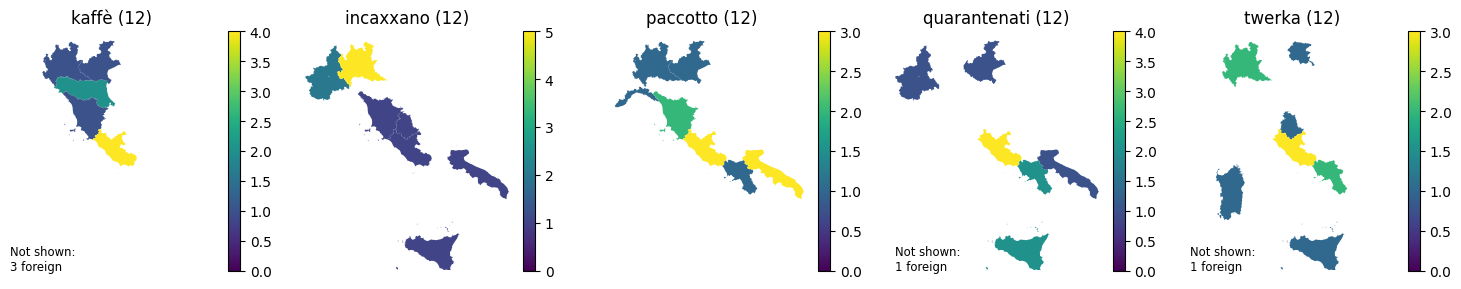

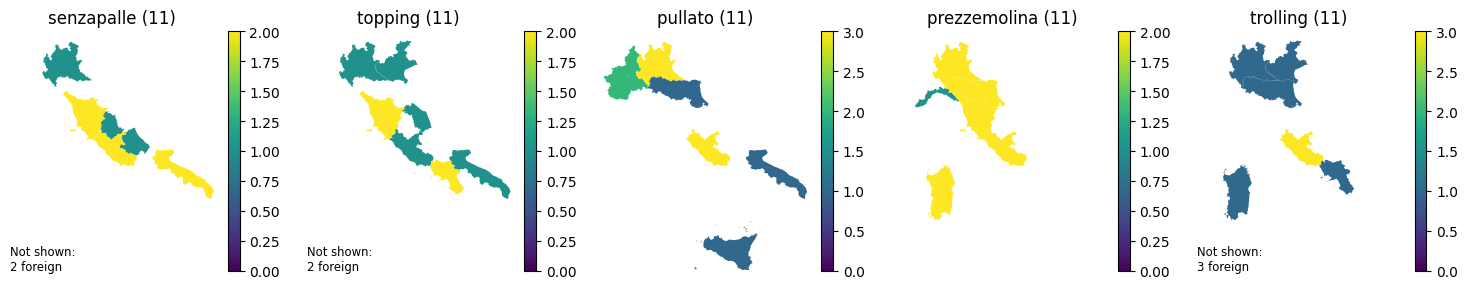

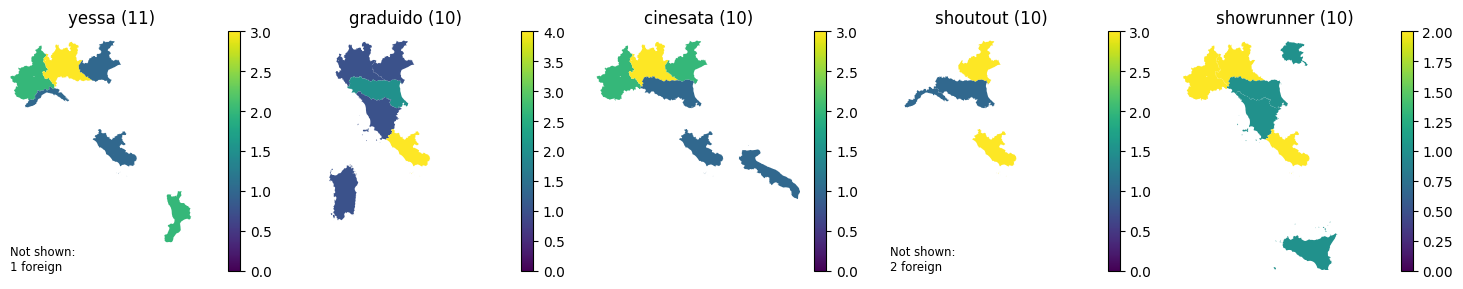

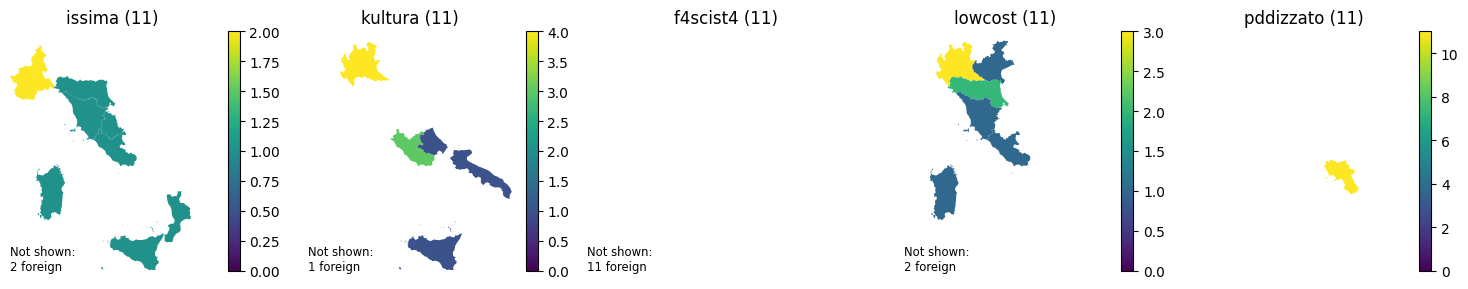

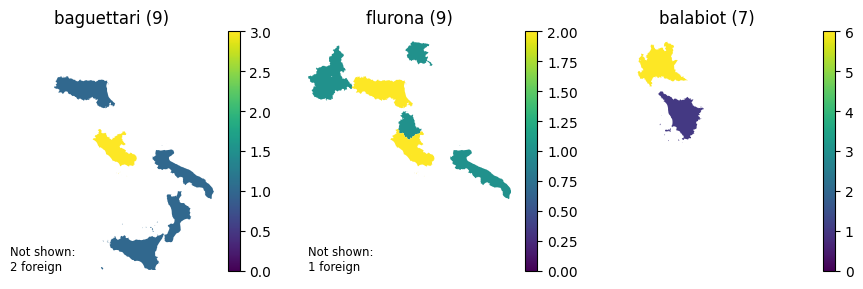

In [7]:
%%capture --no-display
# ^ this just suppresses annoying warnings

sorted_keys = sorted(sums, key=sums.get, reverse=True)
sorted_choros["grp"] = sorted_choros["wf"].apply(lambda wf: sorted_keys.index(wf)//5)

with tqdm(total=len(sums)) as pbar:
    for grp in sorted_choros["grp"].unique():
        #if grp < 21: continue
        #if grp > 22: continue
        fg = sns.FacetGrid(
            sorted_choros[sorted_choros["grp"].eq(grp)],#.head(1000).tail(500),
            col="wf",
            col_wrap=5,
            height=3,
            # Actual boundaries
            # xlim=(6.6272658, 18.7844746),
            # ylim=(35.2889616, 47.0921462),
            # Skip tiny islands for tighter layout
            xlim=(6.616667, 18.516667),
            ylim=(36.688444, 47.083333),
        )

        fg.set(xticks=[], yticks=[])
        sns.despine(bottom=True, left=True)

        # NOTE: unfortunately this can't be parallelized so it's kinda slow
        fg.map_dataframe(annotate, pbar=pbar)

        plt.show()